# Final Project - Business Economics and Financial Data
## Study on the correlations between Delhi climate and basic food prices
#### Luca Agosti (2062889) - luca.agosti@studenti.unipd.it   
#### Aidin Attar (2048654) - aidin.attar@studenti.unipd.it
#### Leonardo Schiavo (2055519) - leonardo.schiavo.1@studenti.unipd.it

In [1]:
#install.packages("tseries")
#install.packages("corrplot")

In [2]:
library("dplyr")
library("tibble")
library("ggplot2")
library("purrr")
library("reshape2")
library("gridExtra")
library("lmtest") 
library("ggcorrplot")
library("zoo")
library("tseries")


#Libraries to work with timeseries and ARIMA
library("fable")
library("tsibble")
library("urca")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: fabletools


Attaching package: ‘tsibble’


The following object is masked from ‘package:zoo’:

    index


The following objects are masked from ‘package:base’:

    intersect, setdiff, union




In [3]:
#Loading the databse

df_train = as_tibble(read.csv("DailyDelhiClimateTrain.csv"))
df_test = as_tibble(read.csv("DailyDelhiClimateTest.csv"))

head(df_train, 10)

names(df_train)

date       meantemp  humidity wind_speed meanpressure
1  2013-01-01 10.000000 84.50000  0.000000  1015.667    
2  2013-01-02  7.400000 92.00000  2.980000  1017.800    
3  2013-01-03  7.166667 87.00000  4.633333  1018.667    
4  2013-01-04  8.666667 71.33333  1.233333  1017.167    
5  2013-01-05  6.000000 86.83333  3.700000  1016.500    
6  2013-01-06  7.000000 82.80000  1.480000  1018.000    
7  2013-01-07  7.000000 78.60000  6.300000  1020.000    
8  2013-01-08  8.857143 63.71429  7.142857  1018.714    
9  2013-01-09 14.000000 51.25000 12.500000  1017.000    
10 2013-01-10 11.000000 62.00000  7.400000  1015.667

[1] "date"         "meantemp"     "humidity"     "wind_speed"   "meanpressure"

In [4]:
# Plotting options for the notebook

options(repr.plot.width=10, repr.plot.height=5)

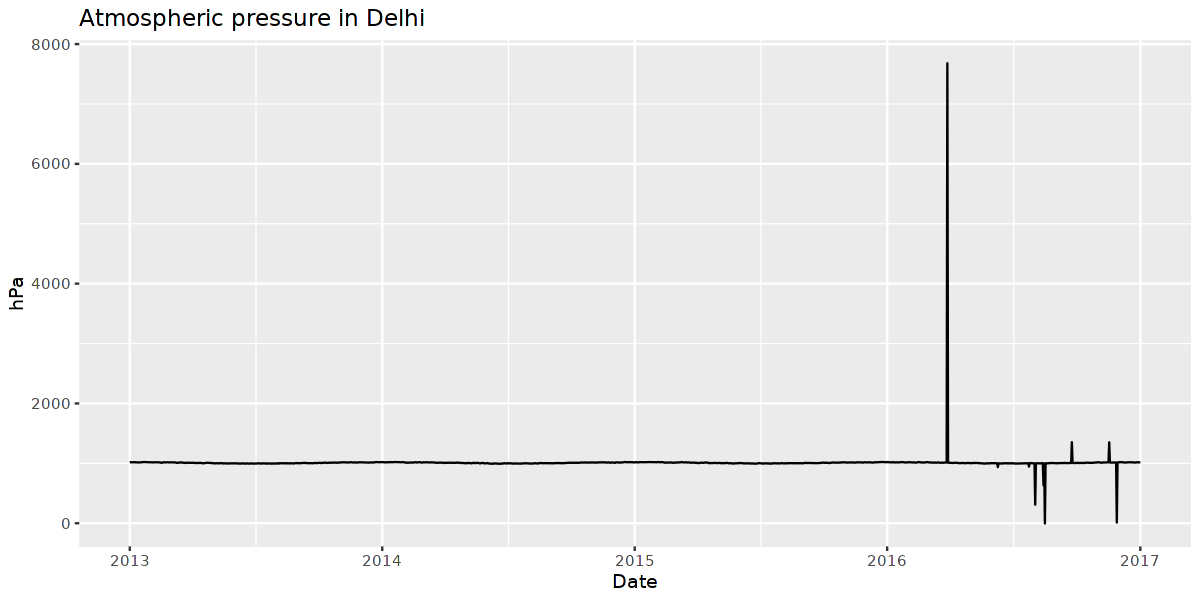

In [5]:
#plot degli outliers della pressione
df_out <- df_train
df_out$date <- as.Date(df_out$date)

meanpressurePlot_out <- ggplot(df_out, aes(x=date, y=meanpressure))+
    geom_line(color="black")+
    ylab("hPa") + 
    xlab("Date") +
    ggtitle('Atmospheric pressure in Delhi')

meanpressurePlot_out 

In [6]:
#Removing the pressure outliers and cleaning the data

df <- df_train
#df %>% filter(meanpressure > 1050 | meanpressure < 980)   #Questi sono gli outliers eliminati se volete vederli
df <- df %>% filter(meanpressure < 1050 & meanpressure > 980)
df$date <- as.Date(df$date)

In [7]:
#summary of the weather time series
library(psych)

summary(df)
describe(df)


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




      date               meantemp        humidity        wind_speed    
 Min.   :2013-01-01   Min.   : 6.00   Min.   : 13.43   Min.   : 0.000  
 1st Qu.:2013-12-30   1st Qu.:18.75   1st Qu.: 50.38   1st Qu.: 3.475  
 Median :2014-12-28   Median :27.71   Median : 62.62   Median : 6.167  
 Mean   :2014-12-28   Mean   :25.47   Mean   : 60.77   Mean   : 6.795  
 3rd Qu.:2015-12-26   3rd Qu.:31.29   3rd Qu.: 72.25   3rd Qu.: 9.203  
 Max.   :2017-01-01   Max.   :38.71   Max.   :100.00   Max.   :42.220  
  meanpressure   
 Min.   : 991.4  
 1st Qu.:1001.6  
 Median :1008.6  
 Mean   :1008.3  
 3rd Qu.:1014.9  
 Max.   :1023.0  

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”


vars n    mean        sd        median      trimmed     mad      
date         1    1453         NaN        NA          NA         NaN        NA
meantemp     2    1453   25.474857  7.358206   27.714286   25.860613  7.247243
humidity     3    1453   60.771971 16.783908   62.625000   61.462460 15.937950
wind_speed   4    1453    6.794871  4.566871    6.166667    6.360073  4.237765
meanpressure 5    1453 1008.269018  7.437835 1008.571429 1008.336691  9.928125
             min       max        range    skew        kurtosis   se       
date               Inf       -Inf     -Inf          NA         NA        NA
meantemp       6.00000   38.71429 32.71429 -0.44099139 -0.9490787 0.1930364
humidity      13.42857  100.00000 86.57143 -0.34402848 -0.3154046 0.4403118
wind_speed     0.00000   42.22000 42.22000  1.43846787  5.0251255 0.1198080
meanpressure 991.37500 1023.00000 31.62500 -0.06683657 -1.2507194 0.1951254

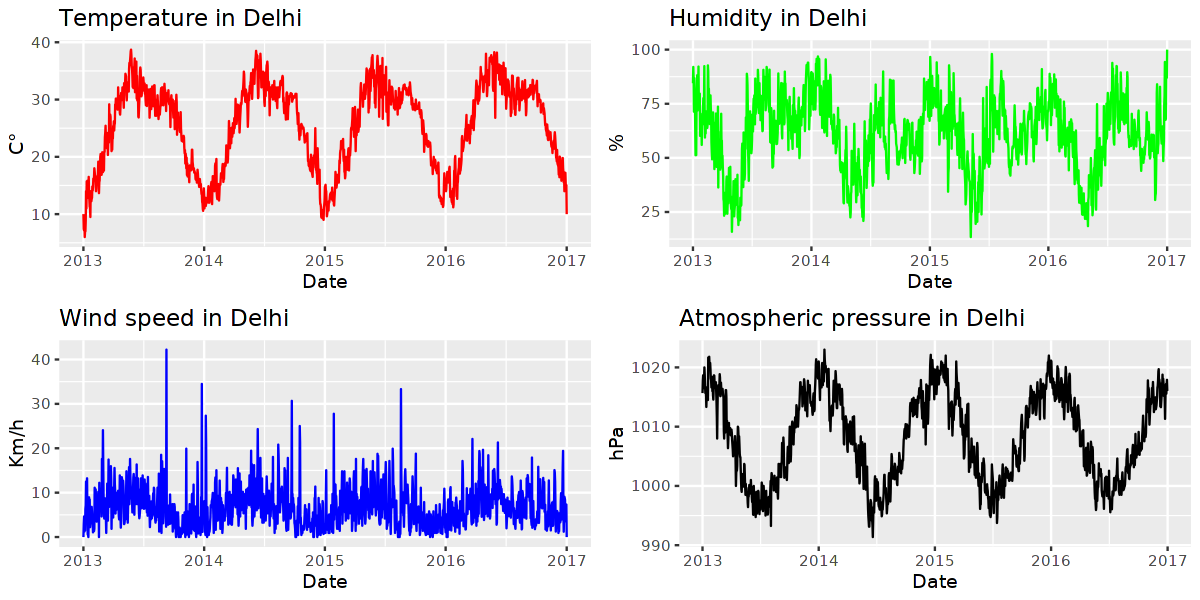

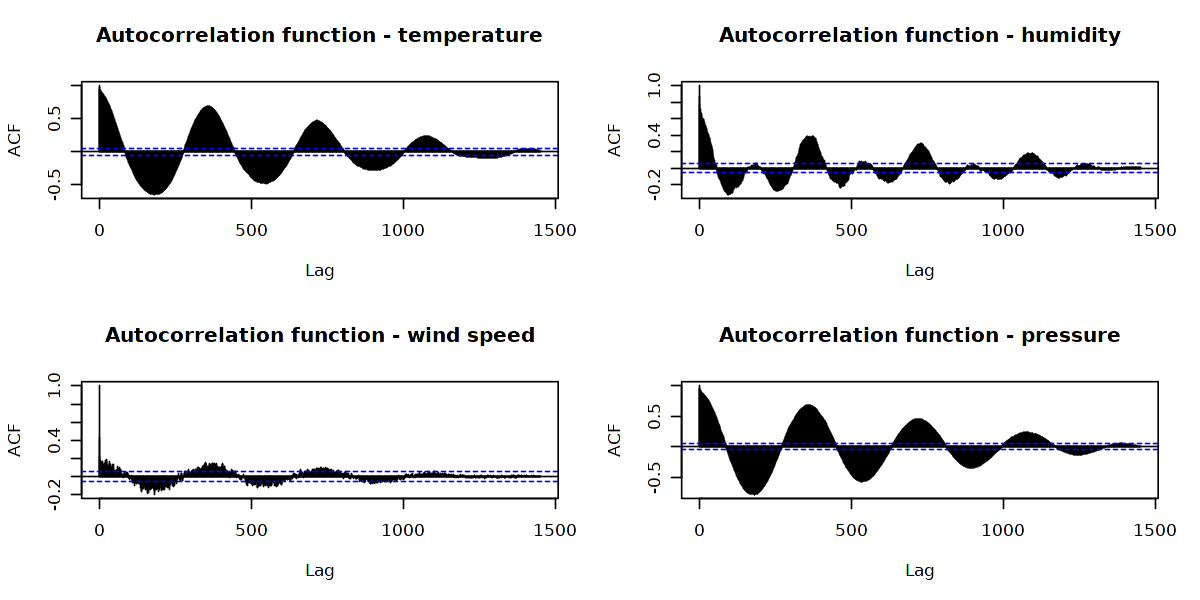

In [8]:
#Vi vanno bene di 3 colori diversi o preferite tutti neri?

meantempPlot<-ggplot(df, aes(x=date, y=meantemp))+
    geom_line(color="red")+
    ylab("C°") + 
    xlab("Date") +
    ggtitle('Temperature in Delhi')

humidityPlot<-ggplot(df, aes(x=date, y=humidity))+
    geom_line(color="green")+
    ylab("%") + 
    xlab("Date") +
    ggtitle('Humidity in Delhi')

wind_speedPlot<-ggplot(df, aes(x=date, y=wind_speed))+
    geom_line(color="blue")+
    ylab("Km/h") + 
    xlab("Date") +
    ggtitle('Wind speed in Delhi')

meanpressurePlot<-ggplot(df, aes(x=date, y=meanpressure))+
    geom_line(color="black")+
    ylab("hPa") + 
    xlab("Date") +
    ggtitle('Atmospheric pressure in Delhi')

grid.arrange(meantempPlot, 
            humidityPlot, 
            wind_speedPlot,
            meanpressurePlot,
            nrow=2, ncol=2
            )

par(mfrow = c(2,2))

#acf_meantemp<-acf(df$meantemp, lag.max=10000, na.action = na.pass)
#acf_humidity<-acf(df$humidity, lag.max=10000, na.action = na.pass)
#acf_wind_speed<-acf(df$wind_speed, lag.max=10000, na.action = na.pass)
#acf_meanpressure<-acf(df$meanpressure, lag.max=10000, na.action = na.pass) #Problema con acf della pressione, colpa della rimozione degli outliers

acf_meantemp <- acf(df$meantemp, lag.max=10000, na.action = na.pass, plot = FALSE)
plot(acf_meantemp, main = "Autocorrelation function - temperature")

acf_humidity <- acf(df$humidity, lag.max=10000, na.action = na.pass, plot = FALSE)
plot(acf_humidity, main = "Autocorrelation function - humidity")

acf_wind_speed <- acf(df$wind_speed, lag.max=10000, na.action = na.pass, plot = FALSE)
plot(acf_wind_speed, main = "Autocorrelation function - wind speed")

acf_meanpressure <- acf(df$meanpressure, lag.max=10000, na.action = na.pass, plot = FALSE)
plot(acf_meanpressure, main = "Autocorrelation function - pressure")

### Correlations

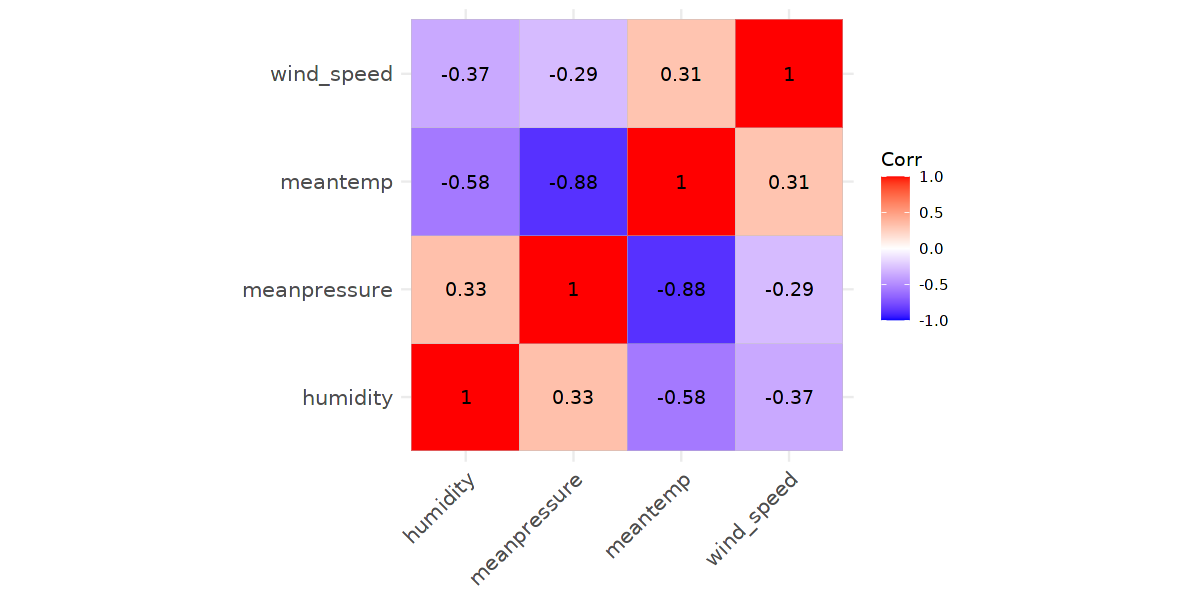

In [9]:
df_cor<-df[,2:5]
ggcorrplot(cor(df_cor), 
            hc.order = TRUE,
            #type = "upper",
            lab = TRUE
            )

corrplot 0.92 loaded



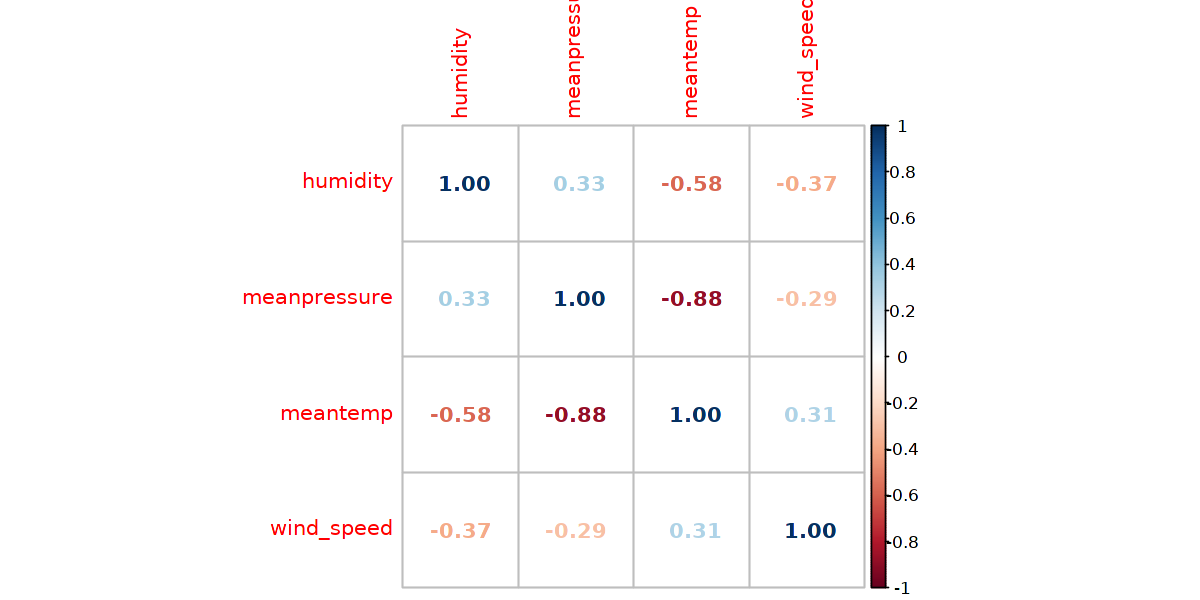

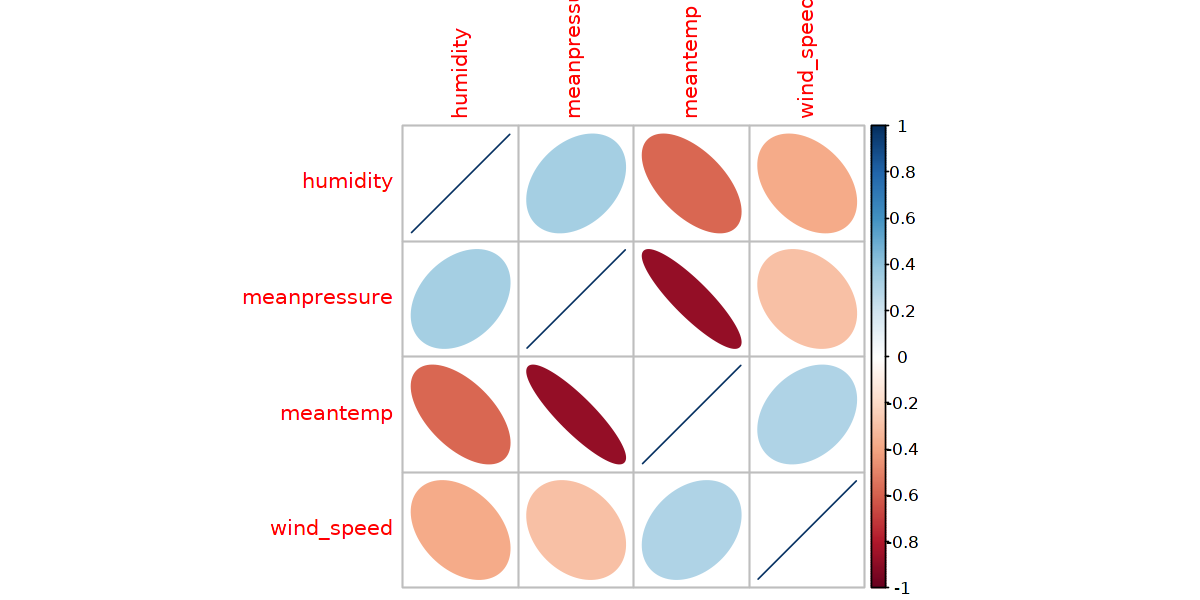

In [10]:
library("corrplot")

M = cor(df_cor)
corrplot(M, method = 'number', order = "alphabet")

corrplot(M, method = 'ellipse', type = 'full', order = 'alphabet')



### Preparing dataframe for ARIMA

In [11]:
#Our period is 365 days, too much to be captured by ARIMA. We build a new dataset considering
#only the first day for each month, in this way our period is 12 and ARIMA is able to catch it

df_12 <- df %>% 
   group_by(yearMon = as.yearmon(date)) %>%
   summarise(date = first(date),
            meantemp = first(meantemp),
            humidity = first(humidity),
            wind_speed = first(wind_speed),
            meanpressure = first(meanpressure)
            )
df_12

yearMon  date       meantemp humidity  wind_speed meanpressure
1  Jan 2013 2013-01-01 10.00000  84.50000  0.000000  1015.6667   
2  Feb 2013 2013-02-01 16.00000  73.00000  2.220000  1016.0000   
3  Mar 2013 2013-03-01 17.33333  49.33333 24.066667  1016.3333   
4  Apr 2013 2013-04-01 25.37500  45.50000  4.400000  1008.5000   
5  May 2013 2013-05-01 31.85714  15.85714 12.685714  1002.8333   
6  Jun 2013 2013-06-01 32.00000  54.00000 13.437500   998.7500   
7  Jul 2013 2013-07-01 33.85714  54.00000  8.728571   996.4286   
8  Aug 2013 2013-08-01 30.00000  73.50000  5.550000   998.0000   
9  Sep 2013 2013-09-01 30.00000  65.20000 11.480000  1003.2000   
10 Oct 2013 2013-10-01 28.28571  68.71429  6.371429  1007.7143   
11 Nov 2013 2013-11-01 23.42857  69.14286  1.057143  1013.2857   
12 Dec 2013 2013-12-01 18.00000  65.00000  1.585714  1016.1429   
13 Jan 2014 2014-01-01 13.37500  89.62500  7.650000  1021.0000   
14 Feb 2014 2014-02-01 14.00000  79.37500  2.550000  1019.7500   
15 Mar 2014 2014-03-01 16.14286  87.28571  4.242857  1015.2857   
16 Apr 2014 2014-04-01 24.87500  45.75000  9.712500  1006.1250   
17 May 2014 2014-05-01 34.87500  22.50000  9.737500  1001.5000   
18 Jun 2014 2014-06-01 32.75000  34.25000 16.200000  1003.2500   
19 Jul 2014 2014-07-01 31.37500  65.12500  6.250000  1000.8750   
20 Aug 2014 2014-08-01 33.25000  59.50000  6.500000   998.0000   
21 Sep 2014 2014-09-01 29.42857  65.85714 15.512500  1001.1250   
22 Oct 2014 2014-10-01 30.42857  52.85714  3.171429  1010.4286   
23 Nov 2014 2014-11-01 22.50000  50.87500  5.325000  1014.1250   
24 Dec 2014 2014-12-01 20.00000  42.62500  8.800000  1013.7500   
25 Jan 2015 2015-01-01 14.75000  72.00000  0.925000  1017.5000   
26 Feb 2015 2015-02-01 15.00000  65.25000  5.100000  1017.7500   
27 Mar 2015 2015-03-01 17.37500  92.75000 14.812500  1011.1250   
28 Apr 2015 2015-04-01 26.42857  59.71429  6.712500  1007.5000   
29 May 2015 2015-05-01 31.25000  43.50000  5.337500  1005.8750   
30 Jun 2015 2015-06-01 29.37500  41.75000 12.512500  1003.2500   
31 Jul 2015 2015-07-01 32.00000  53.25000  4.175000  1001.8750   
32 Aug 2015 2015-08-01 28.25000  71.75000  0.925000  1002.7500   
33 Sep 2015 2015-09-01 32.12500  47.62500 15.275000  1000.8571   
34 Oct 2015 2015-10-01 28.12500  51.25000  5.575000  1012.0000   
35 Nov 2015 2015-11-01 22.87500  70.50000  0.925000  1016.2500   
36 Dec 2015 2015-12-01 19.25000  78.75000  1.625000  1014.7500   
37 Jan 2016 2016-01-01 14.71429  72.28571  1.057143  1021.1429   
38 Feb 2016 2016-02-01 15.84615  65.76923  7.269231  1017.1538   
39 Mar 2016 2016-03-01 24.91667  57.41667  1.700000  1015.0000   
40 Apr 2016 2016-04-01 30.57143  38.21429 12.035714  1006.7143   
41 May 2016 2016-05-01 34.68750  23.37500  8.575000  1002.4375   
42 Jun 2016 2016-06-01 36.00000  42.20000  9.133333  1002.7333   
43 Jul 2016 2016-07-01 32.12500  73.40000  8.350000  1002.5625   
44 Aug 2016 2016-08-01 29.12500  84.25000  5.912500   999.1250   
45 Sep 2016 2016-09-01 27.96000  87.24000  4.148000  1002.4400   
46 Oct 2016 2016-10-01 32.54167  61.91667  3.170833  1007.5000   
47 Nov 2016 2016-11-01 24.38462  58.73077  2.715385  1016.3846   
48 Dec 2016 2016-12-01 19.75000  84.00000  2.704167  1016.8750   
49 Jan 2017 2017-01-01 10.00000 100.00000  0.000000  1016.0000

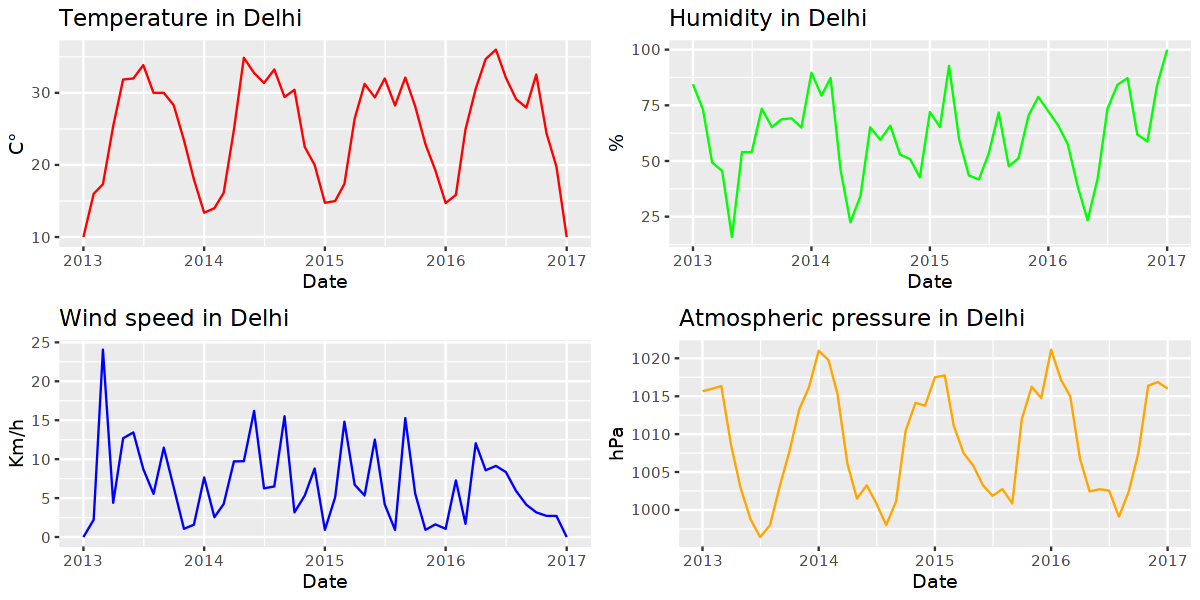

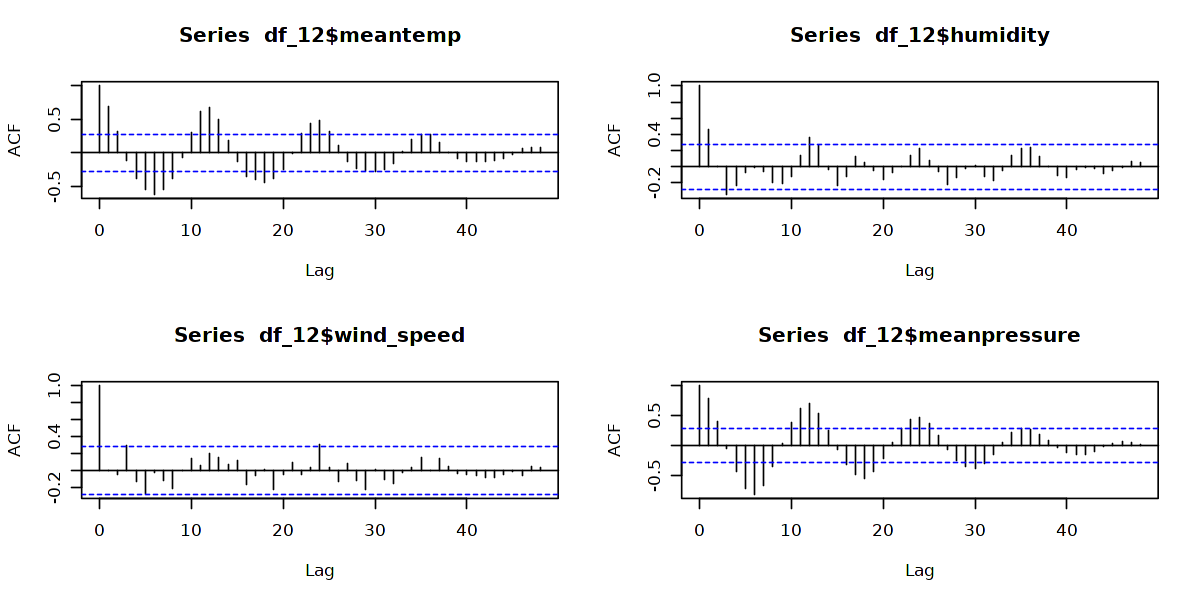

In [12]:
meantempPlot<-ggplot(df_12, aes(x=date, y=meantemp))+
    geom_line(color="red")+
    ylab("C°") + 
    xlab("Date") +
    ggtitle('Temperature in Delhi')

humidityPlot<-ggplot(df_12, aes(x=date, y=humidity))+
    geom_line(color="green")+
    ylab("%") + 
    xlab("Date") +
    ggtitle('Humidity in Delhi')

wind_speedPlot<-ggplot(df_12, aes(x=date, y=wind_speed))+
    geom_line(color="blue")+
    ylab("Km/h") + 
    xlab("Date") +
    ggtitle('Wind speed in Delhi')

meanpressurePlot<-ggplot(df_12, aes(x=date, y=meanpressure))+
    geom_line(color="orange")+
    ylab("hPa") + 
    xlab("Date") +
    ggtitle('Atmospheric pressure in Delhi')

grid.arrange(meantempPlot, 
            humidityPlot, 
            wind_speedPlot, 
            meanpressurePlot, 
            nrow=2, ncol=2
            )

par(mfrow = c(2,2))

acf_meantemp<-acf(df_12$meantemp, lag.max=10000)
acf_humidity<-acf(df_12$humidity, lag.max=10000)
acf_wind_speed<-acf(df_12$wind_speed, lag.max=10000)
acf_meanpressure<-acf(df_12$meanpressure, lag.max=10000)

### ARIMA model fitting & forecasting

In [13]:
# Time series definition

ts_1 <- tibble(
  Date = yearmonth(df_12$yearMon),
  value = df_12$meantemp
)

ts_2 <- tibble(
  Date = yearmonth(df_12$yearMon),
  value = df_12$humidity
)

ts_3 <- tibble(
  Date = yearmonth(df_12$yearMon),
  value = df_12$wind_speed
)

ts_4 <- tibble(
  Date = yearmonth(df_12$yearMon),
  value = df_12$meanpressure
)

tsibble_1<-as_tsibble(ts_1, index=Date)
tsibble_1<-fill_gaps(tsibble_1, .full = FALSE)

tsibble_2<-as_tsibble(ts_2, index=Date)
tsibble_2<-fill_gaps(tsibble_2, .full = FALSE)

tsibble_3<-as_tsibble(ts_3, index=Date)
tsibble_3<-fill_gaps(tsibble_3, .full = FALSE)

tsibble_4<-as_tsibble(ts_4, index=Date)
tsibble_4<-fill_gaps(tsibble_4, .full = FALSE)

fitted_arima_model_1     
1 <ARIMA(0,0,0)(0,1,1)[12]>

fitted_arima_model_2     
1 <ARIMA(1,0,0)(1,1,0)[12]>

fitted_arima_model_3             
1 <ARIMA(0,0,0)(1,0,0)[12] w/ mean>

fitted_arima_model_4     
1 <ARIMA(0,0,0)(1,1,0)[12]>

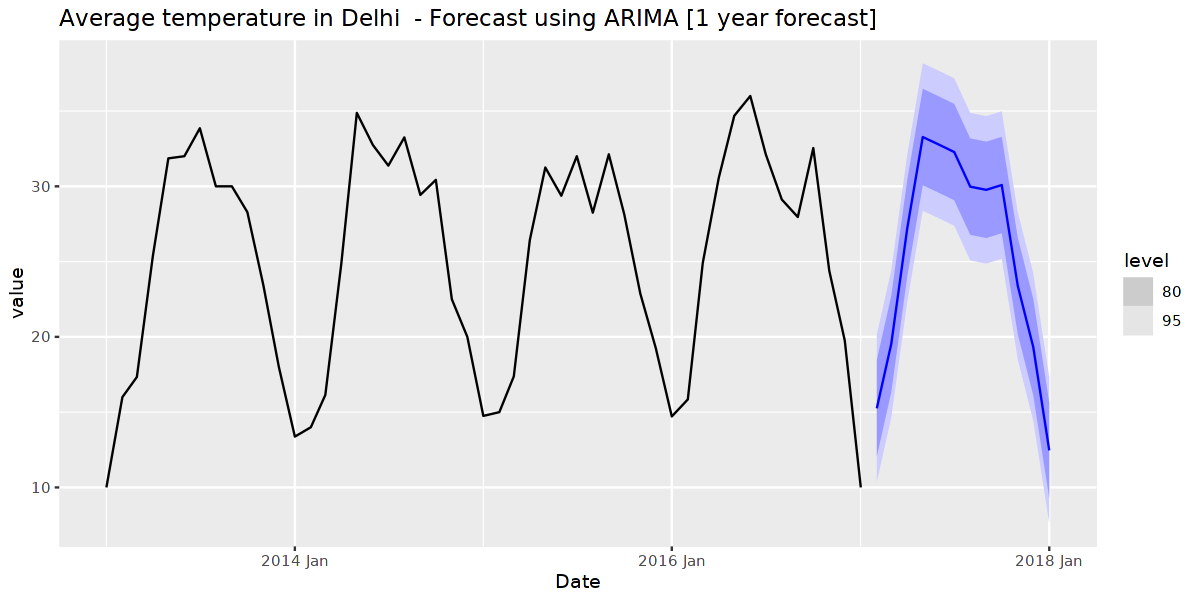

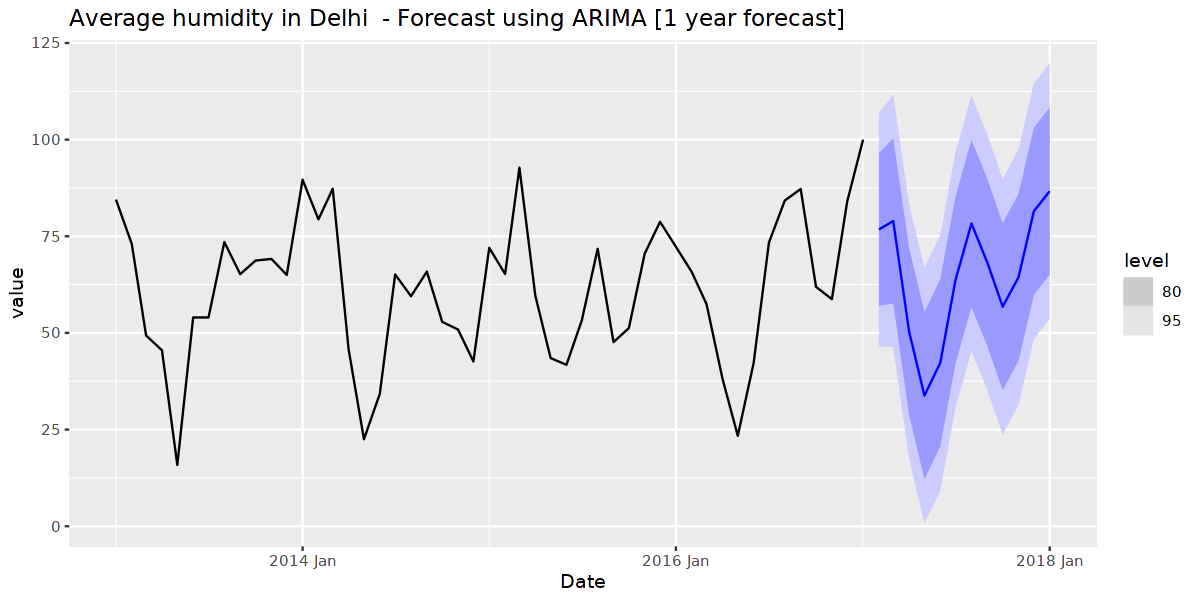

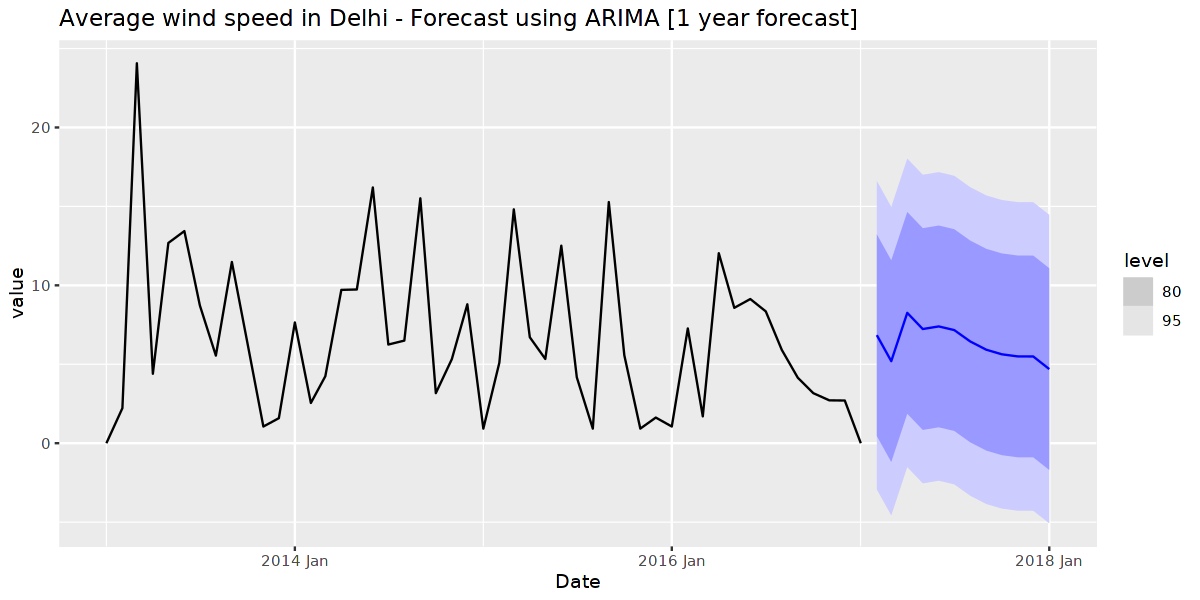

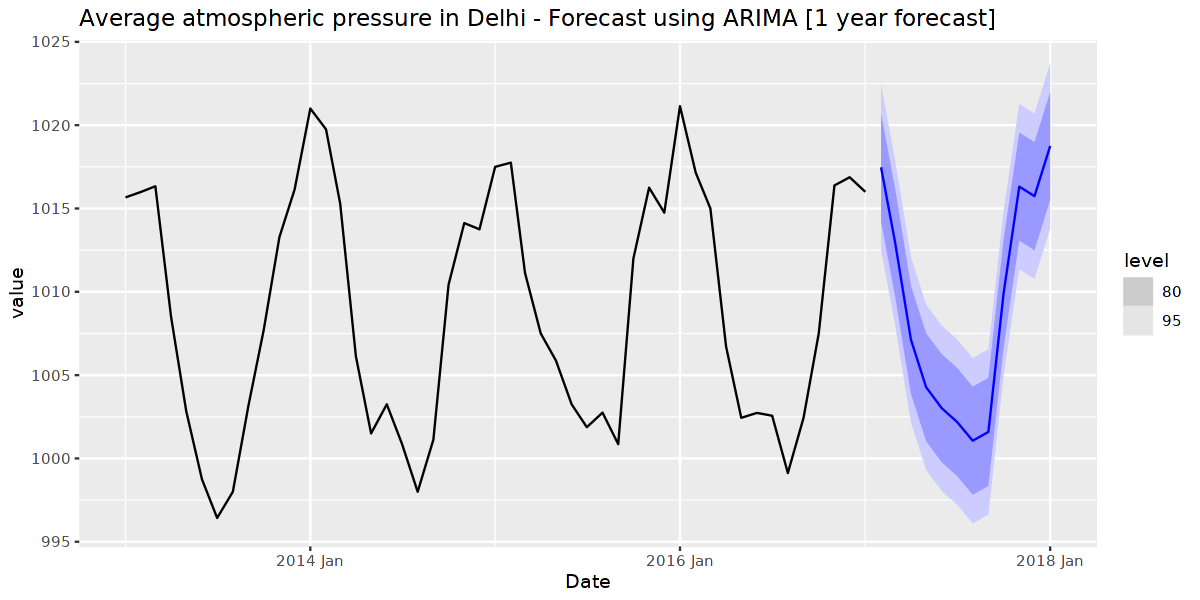

In [14]:
# Forecasting with ARIMA

# Fitting an ARIMA model

fit_ts_1<- tsibble_1 %>%
  model(fitted_arima_model_1 = ARIMA(value ~ pdq() + PDQ()))

fit_ts_2<- tsibble_2 %>%
  model(fitted_arima_model_2 = ARIMA(value ~ pdq() + PDQ()))


fit_ts_3<- tsibble_3 %>%
  model(fitted_arima_model_3 = ARIMA(value ~ pdq() + PDQ()))


fit_ts_4<- tsibble_4 %>%
  model(fitted_arima_model_4 = ARIMA(value ~ pdq() + PDQ()))


fit_ts_1
fit_ts_2
fit_ts_3
fit_ts_4

# Forcasting the time series using the fitted ARIMA model
fc_ts_1 <- fit_ts_1 %>%
  forecast(h = 12)

fc_ts_1%>%
    autoplot(tsibble_1) + 
    ggtitle('Average temperature in Delhi  - Forecast using ARIMA [1 year forecast]')

fc_ts_2 <- fit_ts_2 %>%
  forecast(h = 12)

fc_ts_2%>%
    autoplot(tsibble_2) + 
    ggtitle('Average humidity in Delhi  - Forecast using ARIMA [1 year forecast]')

fc_ts_3 <- fit_ts_3 %>%
  forecast(h = 12)

fc_ts_3%>%
    autoplot(tsibble_3) + 
    ggtitle('Average wind speed in Delhi - Forecast using ARIMA [1 year forecast]')

fc_ts_4 <- fit_ts_4 %>%
  forecast(h = 12)

fc_ts_4%>%
    autoplot(tsibble_4) + 
    ggtitle('Average atmospheric pressure in Delhi - Forecast using ARIMA [1 year forecast]')

### Bass model studies

In [15]:
library(DIMORA)

Loading required package: minpack.lm

Loading required package: numDeriv

Loading required package: forecast


Attaching package: ‘forecast’


The following objects are masked from ‘package:fabletools’:

    accuracy, forecast


Loading required package: deSolve



Call: ( Standard Bass Model )

  BM(series = data_1, display = T)

Residuals:
     Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-27.0983 -12.6983   0.8925  -1.3325   9.8441  22.6545 

Coefficients:
       Estimate    Std.Error         Lower        Upper p-value  
m 1.175294e+04 4.838946e+04 -8.308866e+04 1.065945e+05   0.809  
p 1.986648e-03 8.270463e-03 -1.422316e-02 1.819646e-02   0.811  
q 5.657750e-03 1.156603e-02 -1.701126e-02 2.832676e-02   0.627  
---
 Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Residual standard error  13.49863  on  46  degrees of freedom
 Multiple R-squared:   0.9996248  Residual squared sum:  8833.227

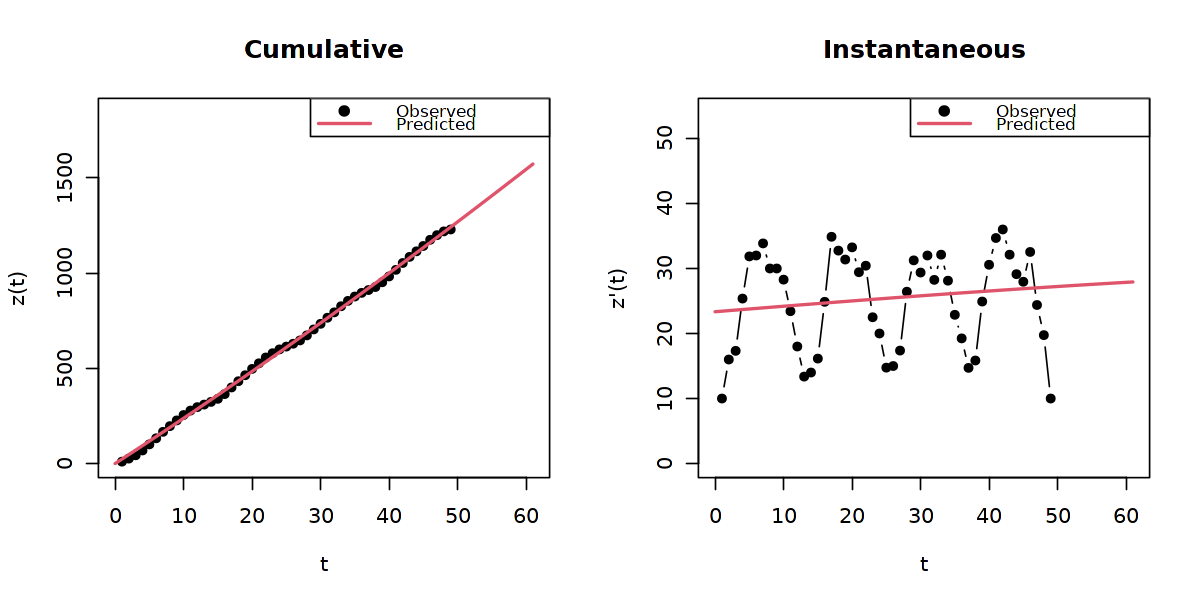

Call: ( Standard Bass Model )

  BM(series = data_2, display = T)

Residuals:
     Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-58.7582 -17.9323   0.4519   1.1954  19.9813  74.6315 

Coefficients:
       Estimate    Std.Error         Lower        Upper p-value  
m 4.123737e+04 5.903122e+05 -1.115753e+06 1.198228e+06   0.945  
p 1.452955e-03 2.114384e-02 -3.998821e-02 4.289412e-02   0.946  
q 1.573921e-03 2.418640e-02 -4.583056e-02 4.897840e-02   0.948  
---
 Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Residual standard error  29.0612  on  46  degrees of freedom
 Multiple R-squared:   0.9997029  Residual squared sum:  40608.58

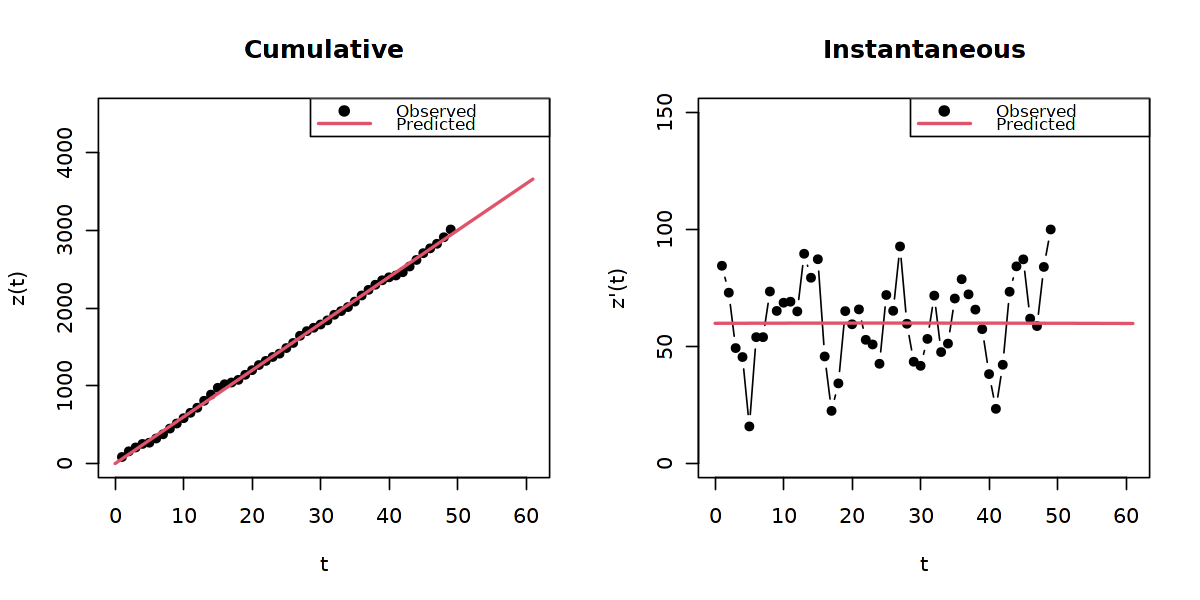

Call: ( Standard Bass Model )

  BM(series = data_3, display = T)

Residuals:
      Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-13.84745  -3.93246   0.67194  -0.06851   4.42793  10.67570 

Coefficients:
       Estimate    Std.Error        Lower        Upper  p-value    
m 529.91500612 79.536572989 3.740262e+02 685.80382464 2.93e-08 ***
p   0.01516419  0.001741208 1.175149e-02   0.01857690 2.73e-11 ***
q   0.01522188  0.007548392 4.273037e-04   0.03001646 4.96e-02   *
---
 Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Residual standard error  6.149903  on  46  degrees of freedom
 Multiple R-squared:   0.9990998  Residual squared sum:  1815.653

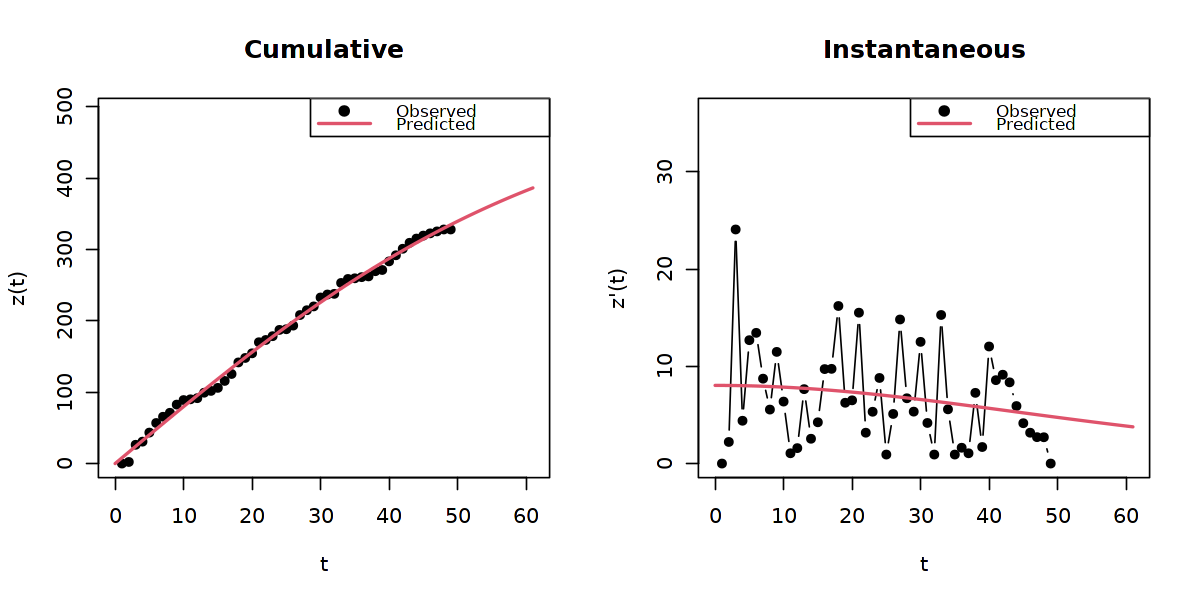

Call: ( Standard Bass Model )

  BM(series = data_4, display = T)

Residuals:
    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-28.323  -7.230   4.229   4.221  16.146  31.922 

Coefficients:
       Estimate    Std.Error        Lower        Upper  p-value    
m 3.570064e+05 4.145372e+04 2.757587e+05 4.382542e+05 3.76e-11 ***
p 2.816073e-03 3.296772e-04 2.169918e-03 3.462229e-03 4.76e-11 ***
q 3.232140e-03 4.313167e-04 2.386775e-03 4.077505e-03 1.67e-09 ***
---
 Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Residual standard error  15.78042  on  46  degrees of freedom
 Multiple R-squared:   0.9999997  Residual squared sum:  12825.99

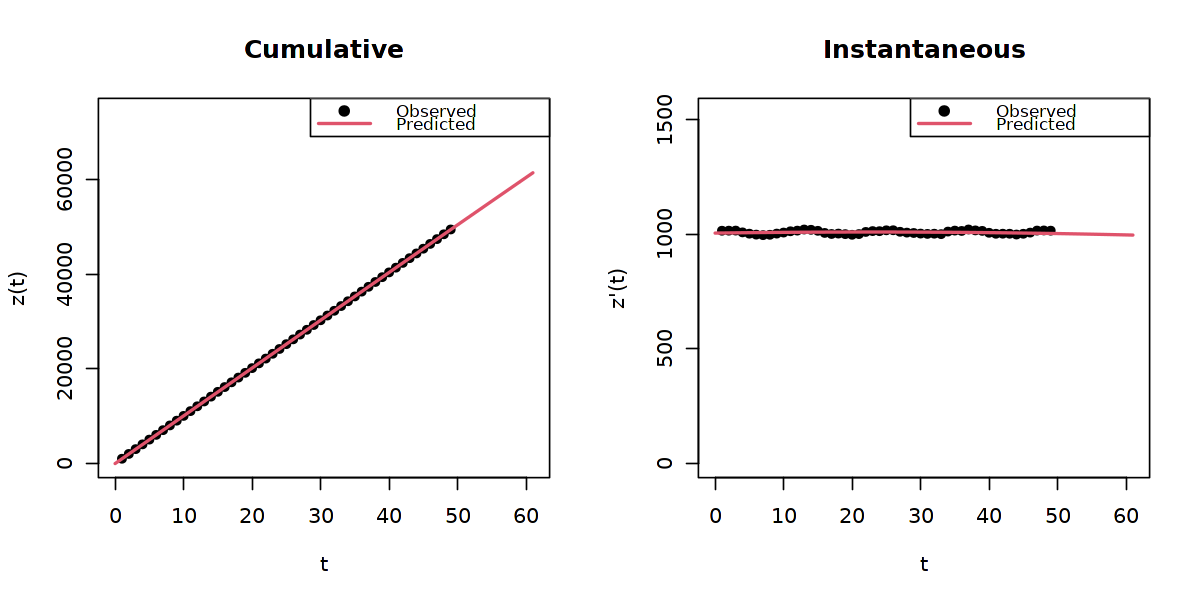

In [16]:
data_1<-df_12$meantemp
data_2<-df_12$humidity
data_3<-df_12$wind_speed
data_4<-df_12$meanpressure

bm_1<-BM(data_1, display = T)
summary(bm_1)


bm_2<-BM(data_2, display = T)
summary(bm_2)


bm_3<-BM(data_3, display = T)
summary(bm_3)


bm_4<-BM(data_4, display = T)
summary(bm_4)

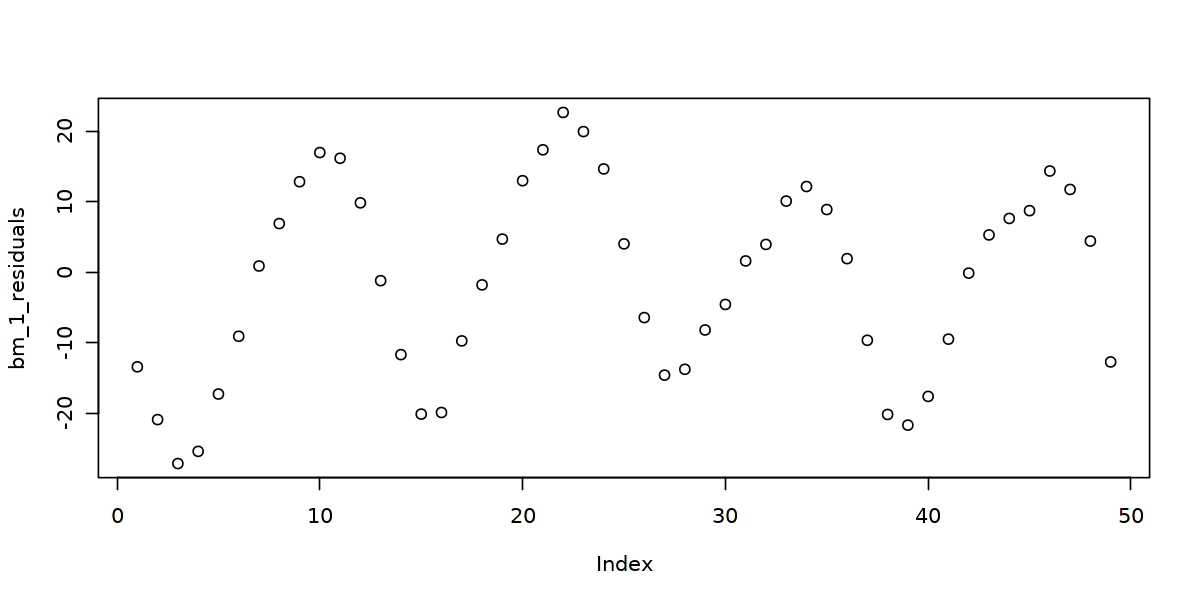

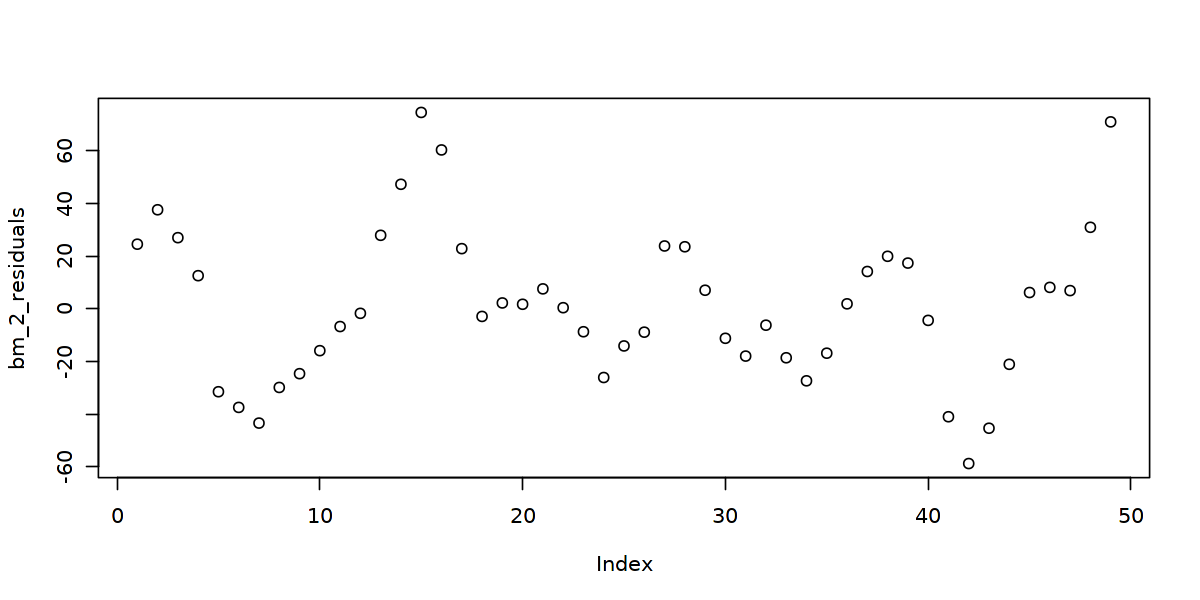

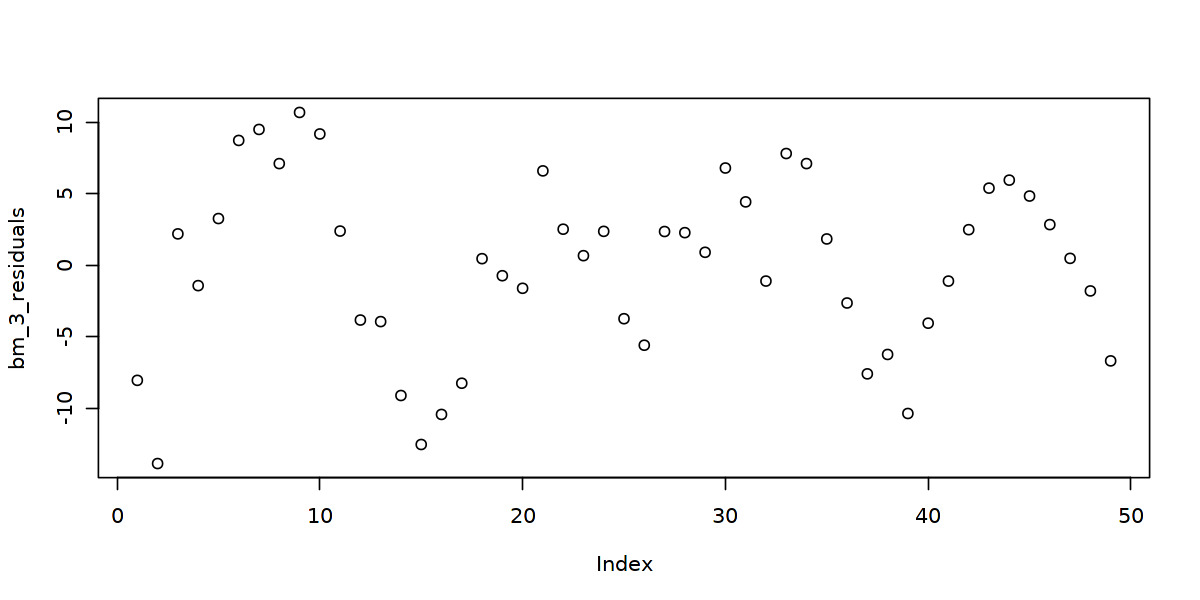

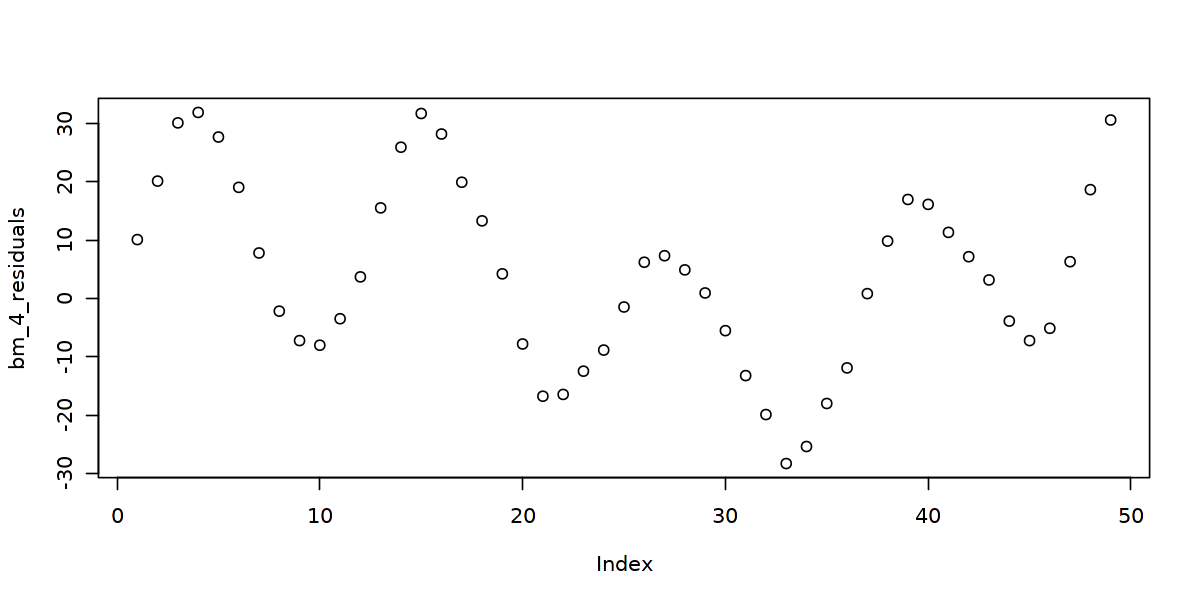

In [17]:
#Bass model's residuals

bm_1_residuals <- residuals(bm_1)
plot(bm_1_residuals)

bm_2_residuals <- residuals(bm_2)
plot(bm_2_residuals)

bm_3_residuals <- residuals(bm_3)
plot(bm_3_residuals)

bm_4_residuals <- residuals(bm_4)
plot(bm_4_residuals)

### Linear Regression

In [18]:
date        <- as.Date(df$date)
index       <- 1:length(date)
temperature <- df$meantemp
humidity    <- df$humidity
wind_speed  <- df$wind_speed
pressure    <- df$meanpressure

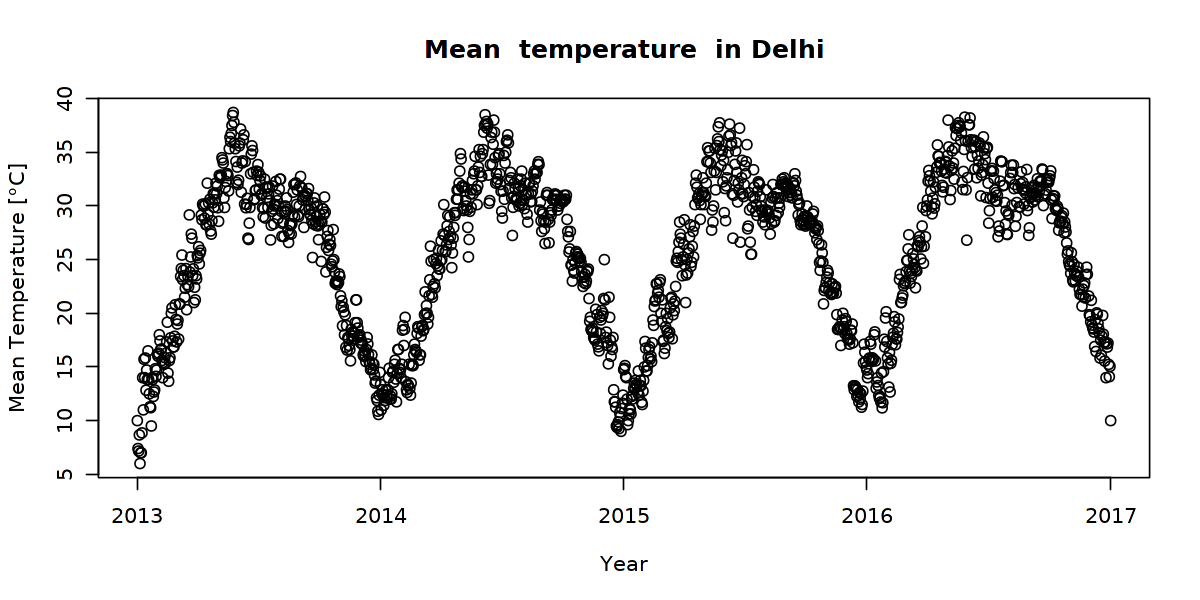

In [19]:
column <- "temperature"

plot(
    date,temperature, 
    main=paste("Mean ", column, " in Delhi"),
    xlab = "Year",
    ylab = "Mean Temperature [°C]"
)

In [20]:
temp.ts <- ts(temperature, frequency=365)
fit.ts.temperature <- tslm(temp.ts~trend+season)

humidity.ts <- ts(humidity, frequency=365)
fit.ts.humidity <- tslm(humidity.ts~trend+season)

ws.ts <- ts(wind_speed, frequency=365)
fit.ts.ws <- tslm(ws.ts~trend+season)

pressure.ts <- ts(pressure, frequency=365)
fit.ts.pressure <- tslm(pressure.ts~trend+season)

summary(fit.ts.temperature)


Call:
tslm(formula = temp.ts ~ trend + season)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.0815 -1.2609  0.0431  1.2790  5.8913 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.3075069  1.0973508  11.216  < 2e-16 ***
trend        0.0016451  0.0001412  11.649  < 2e-16 ***
season2     -1.3927165  1.5480176  -0.900 0.368491    
season3     -0.9214449  1.5480176  -0.595 0.551806    
season4     -0.3605899  1.5480177  -0.233 0.815855    
season5     -1.1643183  1.5480177  -0.752 0.452133    
season6     -1.2671539  1.5480178  -0.819 0.413214    
season7     -1.7464775  1.5480178  -1.128 0.259483    
season8     -1.6633011  1.5480179  -1.074 0.282850    
season9      0.1058872  1.5480180   0.068 0.945478    
season10    -0.6933770  1.5480181  -0.448 0.654305    
season11     0.4210494  1.5480182   0.272 0.785679    
season12     0.6470829  1.5480184   0.418 0.676024    
season13     1.8579379  1.5480185   1.200 0.230322    
season14     0.586

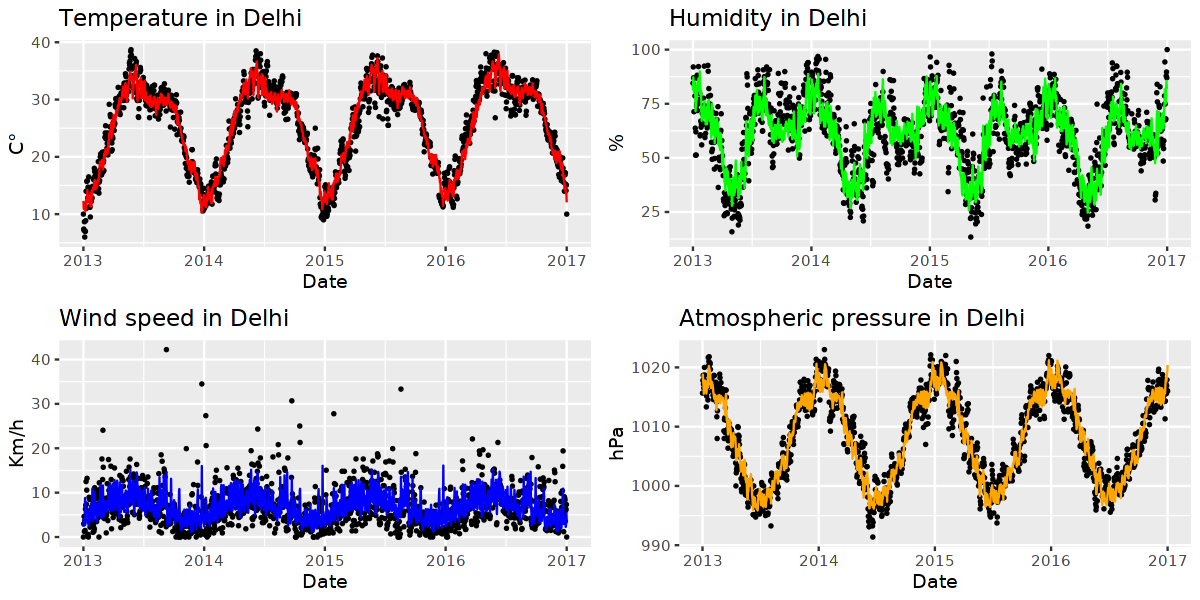

In [21]:
#output <-as.vector(fit.ts.temperature$fitted.values)
output.temp <-fitted(fit.ts.temperature)
output.humidity <-fitted(fit.ts.humidity)
output.ws <-fitted(fit.ts.ws)
output.pressure <-fitted(fit.ts.pressure)

#ggplot(data=df, aes(x=date, y=meantemp)) + geom_point(size=0.1) +
#  geom_line(data = data.frame(fecha=df$date, trend=output), aes(x=date, y=output)) 

meantempPlot<-ggplot(df, aes(x=date, y=meantemp))+
    geom_point(size=0.5)+
    ylab("C°") + 
    xlab("Date") +
    ggtitle('Temperature in Delhi') +
    geom_line(data = data.frame(fecha=df$date, trend=output.temp), aes(x=date, y=output.temp), color="red") 

humidityPlot<-ggplot(df, aes(x=date, y=humidity))+
    geom_point(size=0.5)+
    ylab("%") + 
    xlab("Date") +
    ggtitle('Humidity in Delhi') +
    geom_line(data = data.frame(fecha=df$date, trend=output.humidity), aes(x=date, y=output.humidity), color="green") 

wind_speedPlot<-ggplot(df, aes(x=date, y=wind_speed))+
    geom_point(size=0.5)+
    ylab("Km/h") + 
    xlab("Date") +
    ggtitle('Wind speed in Delhi') +
    geom_line(data = data.frame(fecha=df$date, trend=output.ws), aes(x=date, y=output.ws), color="blue") 

meanpressurePlot<-ggplot(df, aes(x=date, y=meanpressure))+
    geom_point(size=0.5)+
    ylab("hPa") + 
    xlab("Date") +
    ggtitle('Atmospheric pressure in Delhi') +
    geom_line(data = data.frame(fecha=df$date, trend=output.pressure), aes(x=date, y=output.pressure), color="orange") 

grid.arrange(meantempPlot, 
            humidityPlot, 
            wind_speedPlot,
            meanpressurePlot,
            nrow=2, ncol=2
            )


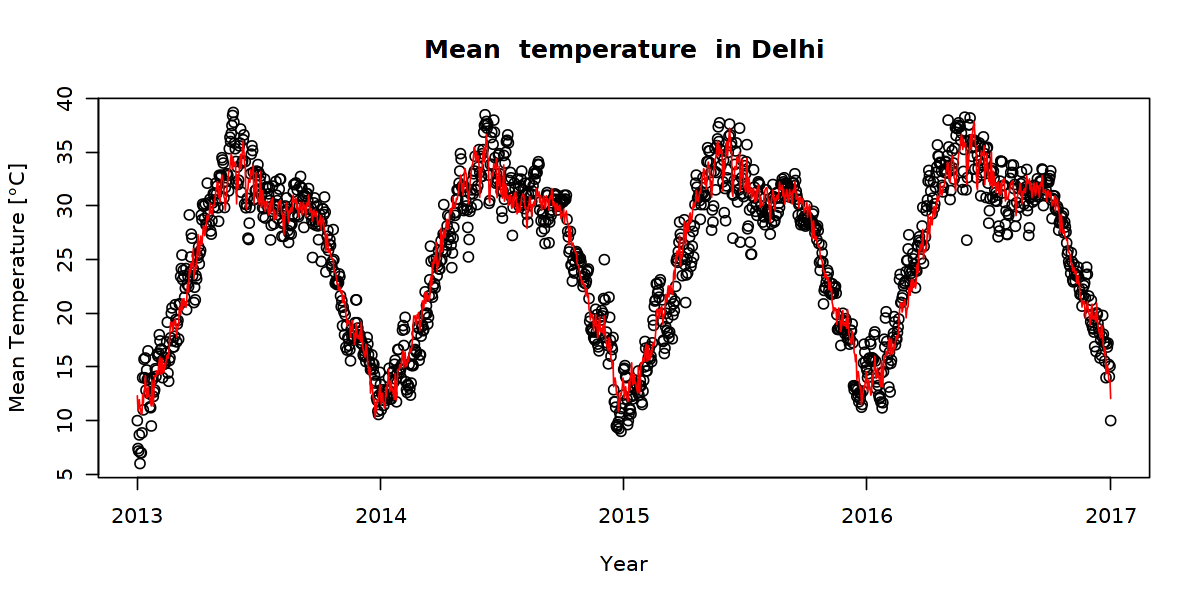

In [22]:
plot(
    date,temp.ts, 
    main=paste("Mean ", column, " in Delhi"),
    xlab = "Year",
    ylab = "Mean Temperature [°C]"
)
lines(date, fitted(fit.ts.temperature), col="red")

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


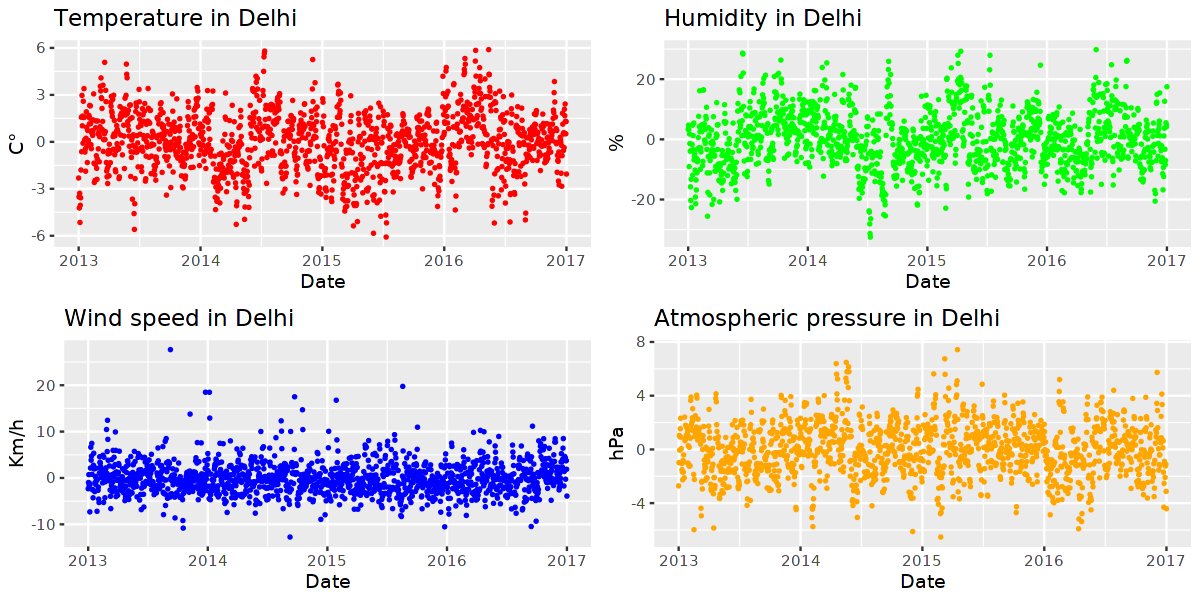

In [23]:
# analysis of residuals
#Residuals <- residuals(fit.ts.temperature) 
#plot(Residuals) 
## the form of residuals seems to indicate the presence of negative autocorrelation
#Acf(Residuals)
#acf(Residuals)

#output <-as.vector(fit.ts.temperature$fitted.values)
output.temp <-residuals(fit.ts.temperature)
output.humidity <-residuals(fit.ts.humidity)
output.ws <-residuals(fit.ts.ws)
output.pressure <-residuals(fit.ts.pressure)

#ggplot(data=df, aes(x=date, y=meantemp)) + geom_point(size=0.1) +
#  geom_line(data = data.frame(fecha=df$date, trend=output), aes(x=date, y=output)) 

meantempPlot<-ggplot(data = data.frame(fecha=df$date, trend=output.temp), aes(x=date, y=output.temp))+
    geom_point(size=0.5, color="red")+
    ylab("C°") + 
    xlab("Date") +
    ggtitle('Temperature in Delhi')

humidityPlot<-ggplot(data = data.frame(fecha=df$date, trend=output.humidity), aes(x=date, y=output.humidity))+
    geom_point(size=0.5, color="green")+
    ylab("%") + 
    xlab("Date") +
    ggtitle('Humidity in Delhi')

wind_speedPlot<-ggplot(data = data.frame(fecha=df$date, trend=output.ws), aes(x=date, y=output.ws))+
    geom_point(size=0.5, color="blue")+
    ylab("Km/h") + 
    xlab("Date") +
    ggtitle('Wind speed in Delhi')

meanpressurePlot<-ggplot(data = data.frame(fecha=df$date, trend=output.pressure), aes(x=date, y=output.pressure))+
    geom_point(size=0.5, color="orange")+
    ylab("hPa") + 
    xlab("Date") +
    ggtitle('Atmospheric pressure in Delhi')

grid.arrange(meantempPlot, 
            humidityPlot, 
            wind_speedPlot,
            meanpressurePlot,
            nrow=2, ncol=2
            )




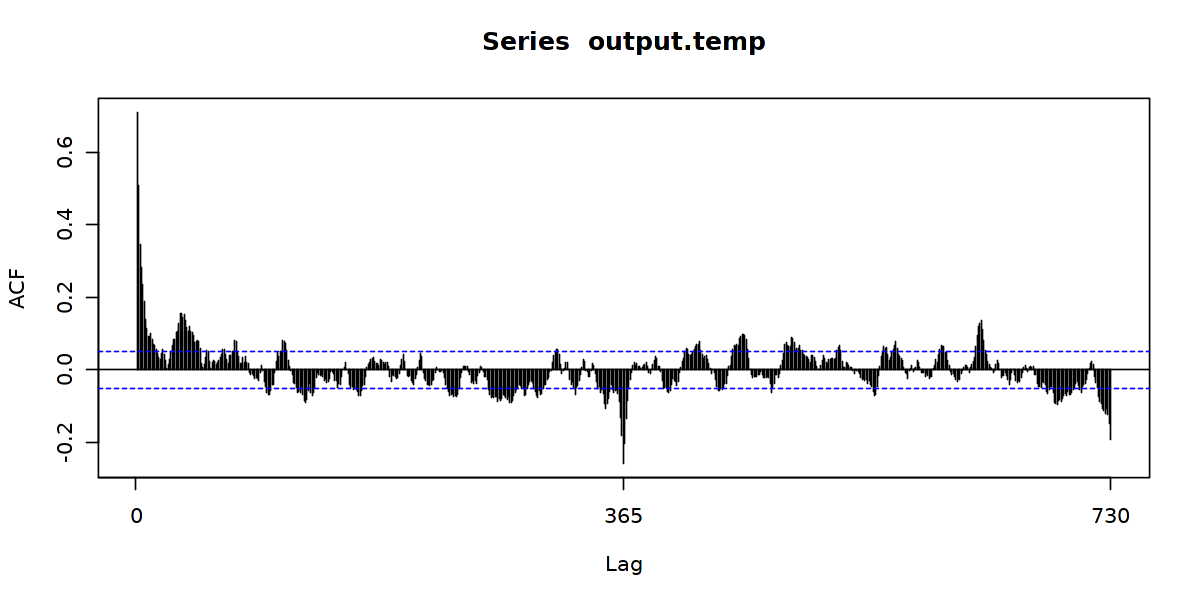

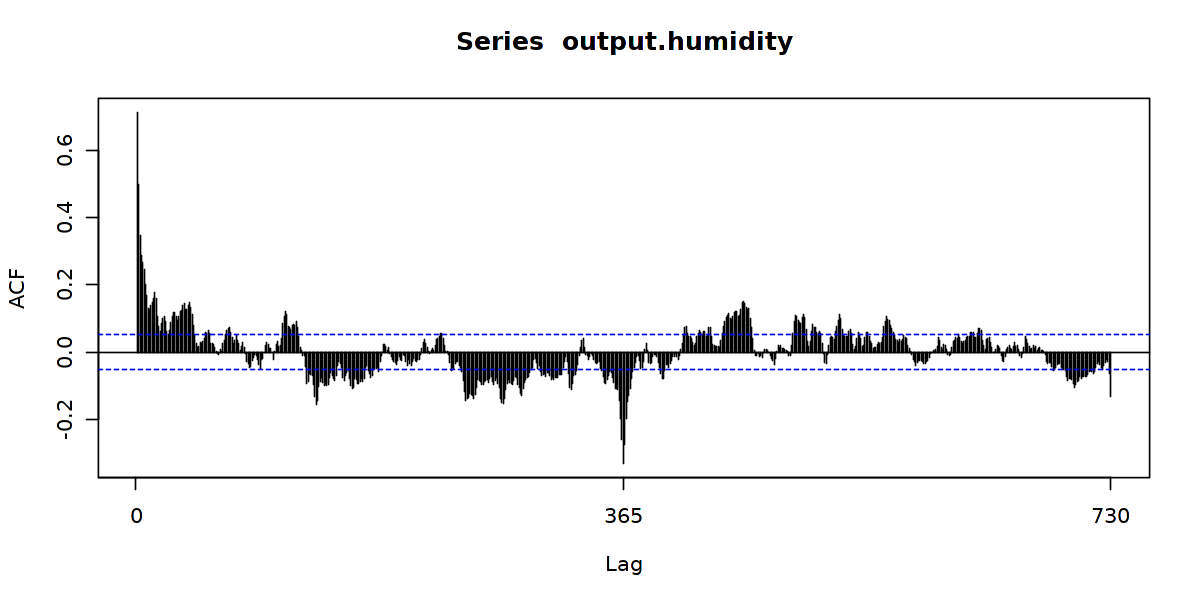

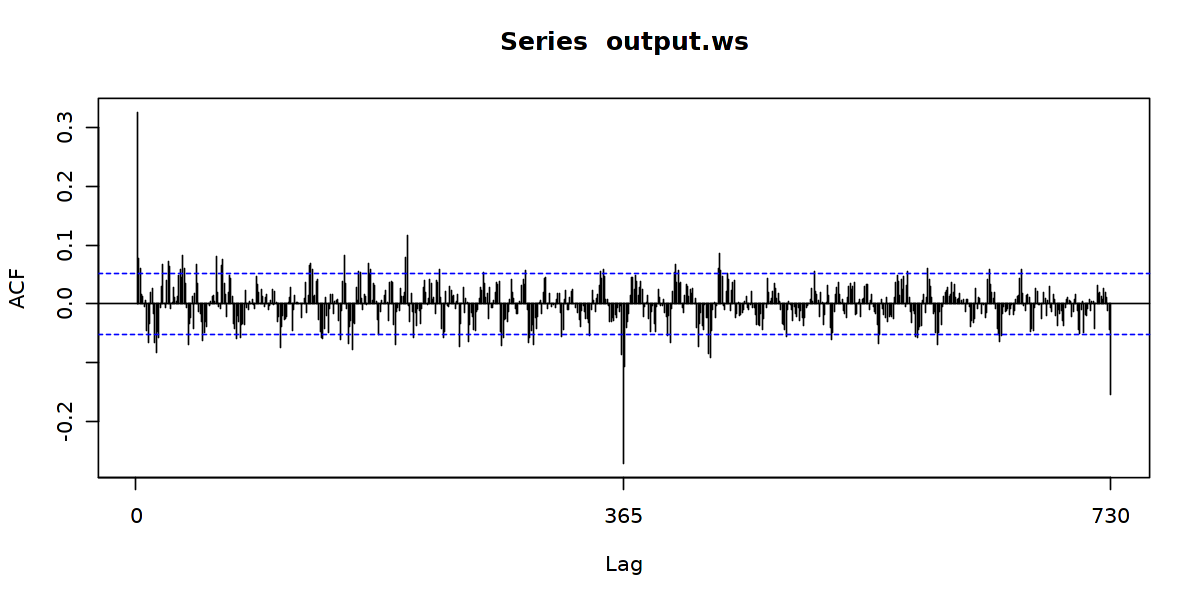

Warning message in ggplot2::geom_segment(lineend = "butt", ...):
“Ignoring unknown parameters: `main`”
Warning message in ggplot2::geom_segment(lineend = "butt", ...):
“Ignoring unknown parameters: `main`”
Warning message in ggplot2::geom_segment(lineend = "butt", ...):
“Ignoring unknown parameters: `main`”
Warning message in ggplot2::geom_segment(lineend = "butt", ...):
“Ignoring unknown parameters: `main`”


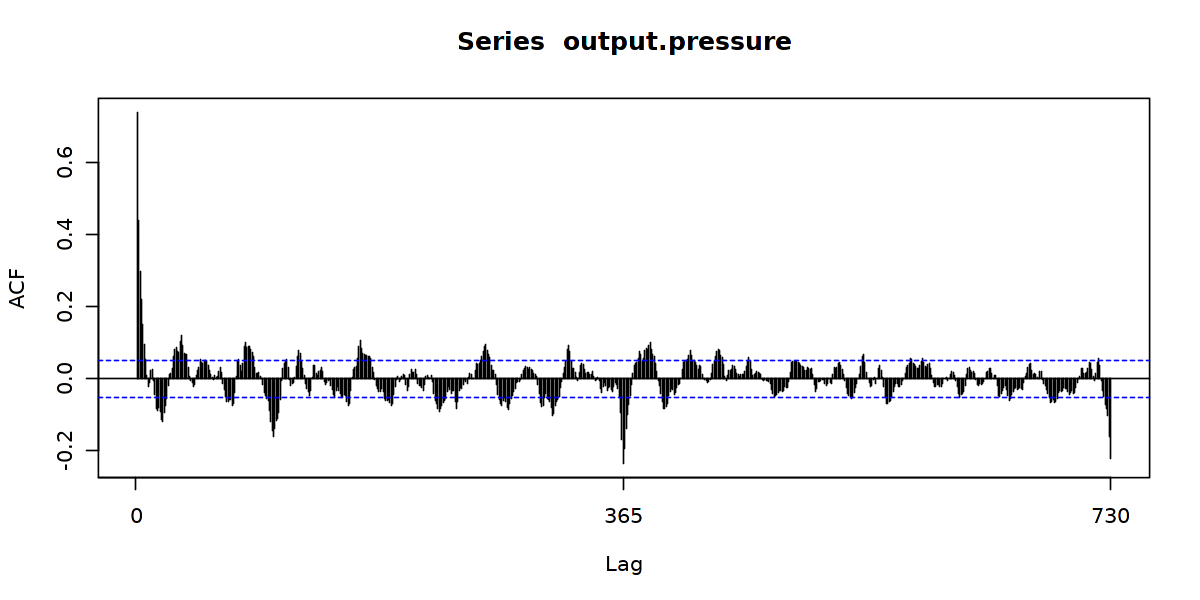

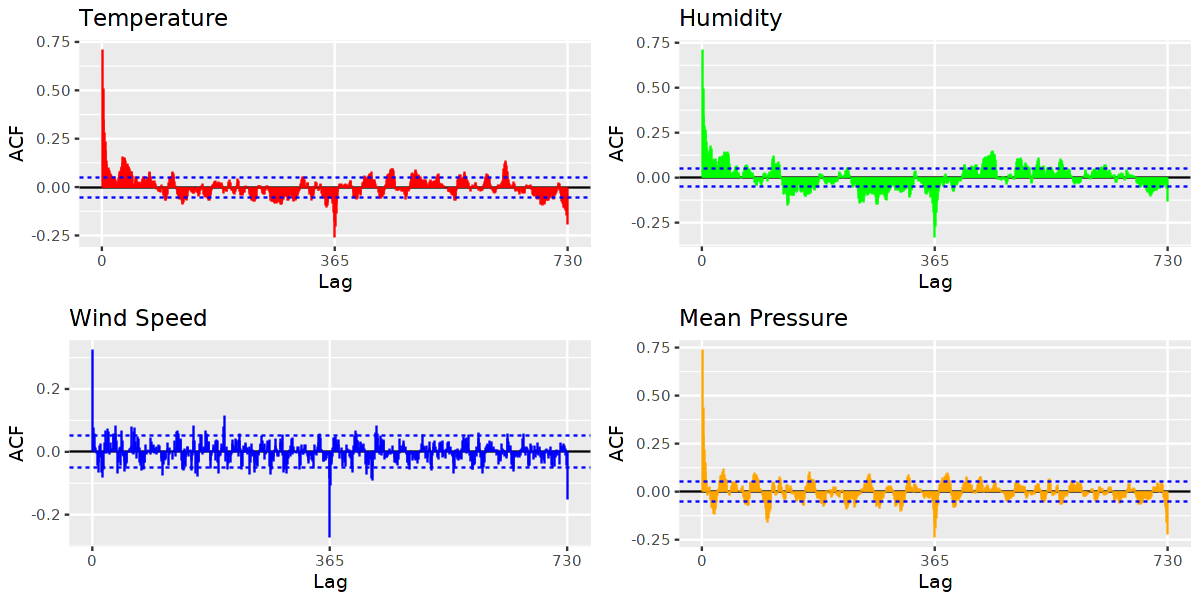

In [24]:
acf_meantemp     <-Acf(output.temp)
acf_humidity     <-Acf(output.humidity)
acf_wind_speed   <-Acf(output.ws)
acf_meanpressure <-Acf(output.pressure)

acf_meantempPlot<-autoplot(acf_meantemp, main = "Temperature", col="red")
acf_humidityPlot<-autoplot(acf_humidity, main = "Humidity", col="green")
acf_wind_speedPlot<-autoplot(acf_wind_speed, main = "Wind Speed", col="blue")
acf_meanpressurePlot<-autoplot(acf_meanpressure, main = "Mean Pressure", col="orange")


grid.arrange(acf_meantempPlot, 
             acf_humidityPlot, 
             acf_wind_speedPlot,
             acf_meanpressurePlot,
             nrow=2, ncol=2
            )

In [25]:
dw.temp <- dwtest(fit.ts.temperature, alt="two.sided")
dw.temp
dw.humidity <- dwtest(fit.ts.humidity, alt="two.sided")
dw.humidity
dw.ws <- dwtest(fit.ts.ws, alt="two.sided")
dw.ws
dw.pressure <- dwtest(fit.ts.pressure, alt="two.sided")
dw.pressure



	Durbin-Watson test

data:  fit.ts.temperature
DW = 0.57772, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is not 0



	Durbin-Watson test

data:  fit.ts.humidity
DW = 0.57421, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is not 0



	Durbin-Watson test

data:  fit.ts.ws
DW = 1.3483, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is not 0



	Durbin-Watson test

data:  fit.ts.pressure
DW = 0.51699, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is not 0


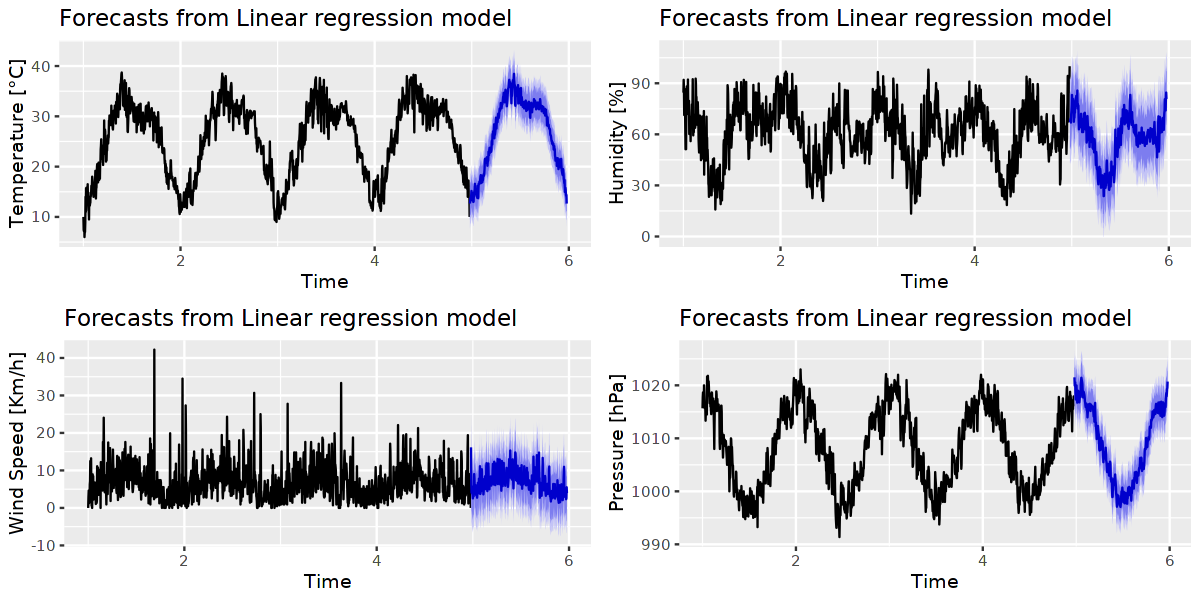

In [26]:
forecast.temperature <- forecast(fit.ts.temperature, h=365)

forecast.humidity <- forecast(fit.ts.humidity, h=365)

forecast.ws <- forecast(fit.ts.ws, h=365)

forecast.pressure <- forecast(fit.ts.pressure, h=365)
meantempPlot<-autoplot(forecast.temperature,  ylab="Temperature [°C]" )
humidityPlot<-autoplot(forecast.humidity,     ylab="Humidity [%]"     )
wind_speedPlot<-autoplot(forecast.ws,         ylab="Wind Speed [Km/h]")
meanpressurePlot<-autoplot(forecast.pressure, ylab="Pressure [hPa]"   )

grid.arrange(meantempPlot, 
             humidityPlot, 
             wind_speedPlot,
             meanpressurePlot,
             nrow=2, ncol=2
            )

In [27]:
accuracy(forecast.temperature, test = df_test$meantemp)
accuracy(forecast.humidity, test = df_test$humidity)
accuracy(forecast.ws, test = df_test$wind_speed)
accuracy(forecast.pressure, test = df_test$meanpressure)

ME       RMSE     MAE     MPE      MAPE     MASE ACF1     
Training set 1.002428 1.610721 1.27132 6.407378 8.787903 NaN  0.3808032

ME        RMSE     MAE      MPE      MAPE     MASE ACF1     
Training set -3.686327 9.131689 7.025566 -8.04474 12.44007 NaN  0.2391161

ME        RMSE     MAE      MPE  MAPE MASE ACF1      
Training set 0.4336615 4.321414 3.558777 -Inf Inf  NaN  0.06417866

ME        RMSE     MAE      MPE        MAPE      MASE ACF1     
Training set 0.7721688 2.054805 1.709545 0.07603235 0.1692507 NaN  0.4974102

In [28]:
residuals.test <- data.frame(forecast_temperature)$Point.Forecast[1:length(df_test$meantemp)] - df_test$meantemp

plot(as.Date(df_test$date), residuals.test/df_test$meantemp*100, type='p')

ERROR: Error in data.frame(forecast_temperature): object 'forecast_temperature' not found


In [28]:
library(gam)

tt <- 1:length(temperature)
seas <- factor(c(rep(1:365,length(temperature)/365),1:2)) 

Loading required package: splines

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loaded gam 1.22




In [29]:
# Values for df should be greater than 1, with df=1 implying a linear fit. Default is df=4
gam.temperature <- gam(temperature~s(tt)+seas+s(humidity))
summary(gam.temperature)

ERROR: Error in model.frame.default(formula = temperature ~ s(tt) + seas + s(humidity), : variable lengths differ (found for 'seas')


[1] 6046.942

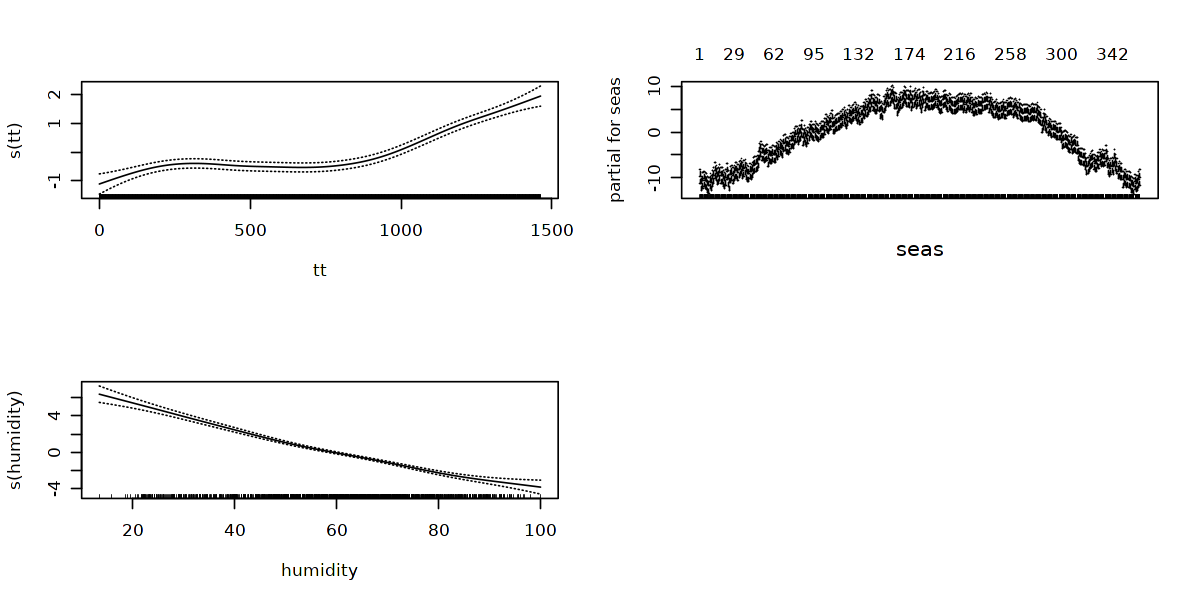

In [ ]:
#######time and Japan have a nonlinear effect (always take care of interpretability!)

par(mfrow=c(2,2))
plot(gam.temperature, se=T)
AIC(gam.temperature)


Call: gam(formula = temperature ~ lo(tt) + seas + lo(humidity))
Deviance Residuals:
      Min        1Q    Median        3Q       Max 
-5.129539 -0.944651  0.003492  0.970701  5.403717 

(Dispersion Parameter for gaussian family taken to be 2.983)

    Null Deviance: 78886.13 on 1461 degrees of freedom
Residual Deviance: 3251.284 on 1089.924 degrees of freedom
AIC: 6063.624 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
                 Df Sum Sq Mean Sq F value    Pr(>F)    
lo(tt)          1.0   1423 1423.12  477.07 < 2.2e-16 ***
seas          364.0  72576  199.38   66.84 < 2.2e-16 ***
lo(humidity)    1.0   1859 1858.62  623.06 < 2.2e-16 ***
Residuals    1089.9   3251    2.98                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Anova for Nonparametric Effects
             Npar Df Npar F     Pr(F)    
(Intercept)                              
lo(tt)           2.3 34.926 < 2.2e-16 ***
seas                                   

[1] 6063.624

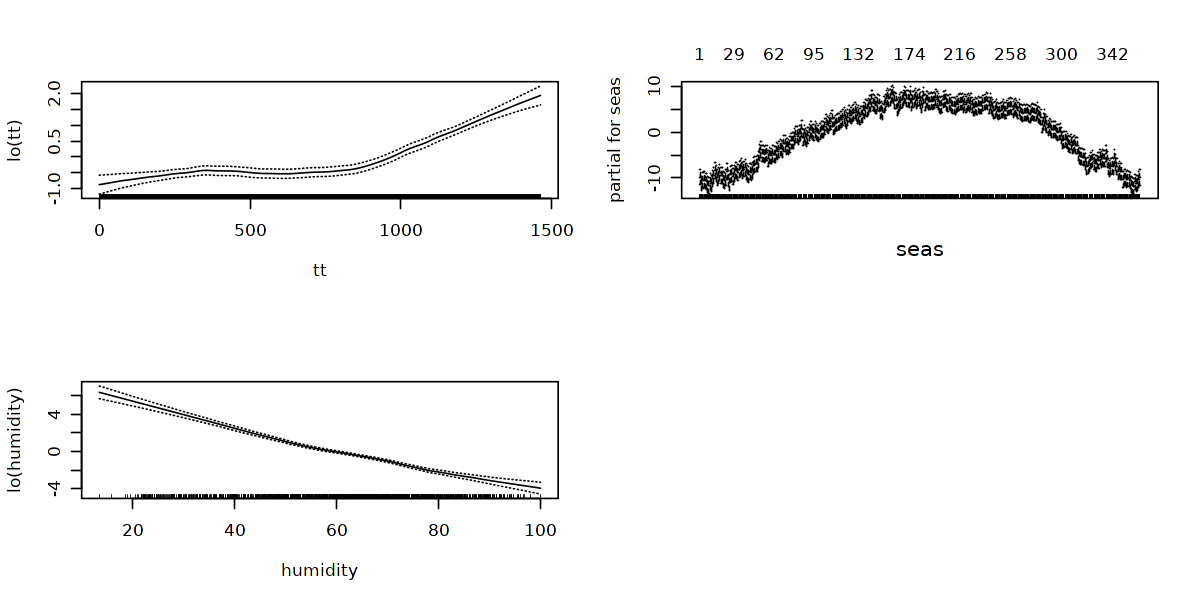

In [ ]:
####try another option with loess (lo)
gam.temperature.loess <- gam(temperature~lo(tt)+seas+lo(humidity))
summary(gam.temperature.loess)
par(mfrow=c(2,2))
plot(gam.temperature.loess, se=T)
AIC(gam.temperature.loess)

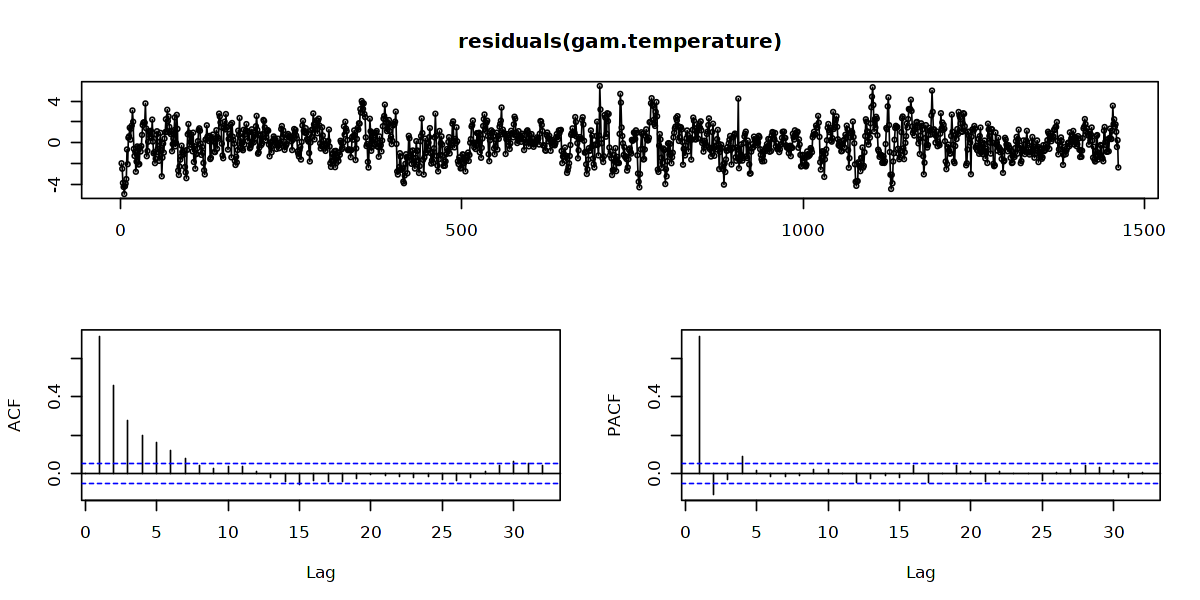

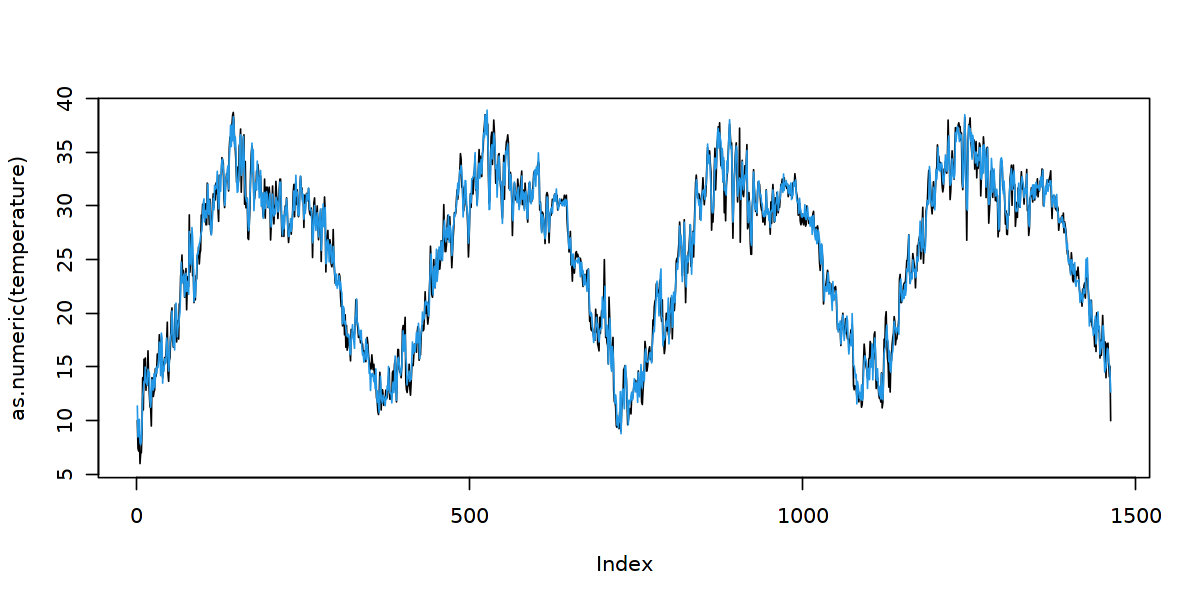

In [ ]:
#######perform analysis of residuals
tsdisplay(residuals(gam.temperature))
aar1<- auto.arima(residuals(gam.temperature))

plot(as.numeric(temperature), type="l")
lines(fitted(aar1)+ fitted(gam.temperature), col=4)

In [ ]:
#forecast_temperature.gam <- forecast(gam.temperature, h=365)
#plot(forecast_temperature)

### Basic food price analysis

In [29]:
#Loading the datasets

df_india_original = as_tibble(read.csv("india.csv"))

df_india_original$date <- as.yearmon(df_india_original$date)

df_india <- df_india_original %>%
    filter(date > "Dec 2012" & date < "Feb 2017")

df_india_test <- df_india_original %>%
    filter(date > "Dec 2012" & date < "Feb 2018") #Anche se lo chiamo test in realtà è test+train

df_india

names(df_india)

date     Chickpeas Oil..mustard. Potatoes Rice     Sugar    Wheat   
1  Jan 2013  69.3225  104.72295     14.63646 221.0802 174.8686 198.3005
2  Feb 2013  63.9750  104.74977     14.07729 226.6646 173.8828 204.6400
3  Mar 2013  60.9425  103.89682     13.43064 226.6332 173.3722 210.2631
4  Apr 2013  58.2200  102.22750     13.94596 224.3121 169.7469 206.5352
5  May 2013  55.4950  100.59409     15.54043 229.0694 170.1296 204.8364
6  Jun 2013  53.7750   99.56000     16.80625 227.9257 167.1402 206.6898
7  Jul 2013  52.1050   98.70262     17.93170 245.4423 167.8186 211.4326
8  Aug 2013  50.9650   96.91780     17.72660 236.6579 167.3524 207.4267
9  Sep 2013  51.4650   96.80275     17.41543 239.6317 169.8260 207.9836
10 Oct 2013  50.0325   95.93561     18.88896 224.2492 164.0888 198.9391
11 Nov 2013  50.2675   98.59442     25.18122 217.1474 159.7269 202.5467
12 Dec 2013  51.4775   99.80432     22.08959 219.7628 158.3051 207.2889
13 Jan 2014  51.1775   98.50814     18.14143 219.8722 155.3524 203.2449
14 Feb 2014  51.2975   98.06930     15.55714 222.2942 151.7700 206.5924
15 Mar 2014  49.1625   97.56512     16.19735 221.4330 152.4524 205.2280
16 Apr 2014  51.2775   98.67023     17.83286 220.6398 161.8047 194.3333
17 May 2014  51.0000   98.49318     20.53143 222.5888 166.5996 198.4964
18 Jun 2014  49.5700   97.70400     21.59327 223.0578 167.7235 199.8420
19 Jul 2014  48.5325   97.61422     24.07271 232.2559 172.3984 200.1309
20 Aug 2014  48.1925   97.00545     26.15875 235.8657 169.2862 203.3332
21 Sep 2014  46.8075   97.02250     28.25187 239.0298 165.0196 201.5155
22 Oct 2014  47.3775   97.15023     29.00396 232.6158 162.1294 198.4134
23 Nov 2014  47.1900   97.80889     29.54896 229.9462 158.9382 199.4845
24 Dec 2014  46.7350   98.04600     23.89750 218.8113 152.1626 196.1920
25 Jan 2015  49.0450   99.37863     18.57582 187.2354 135.2791 172.8575
26 Feb 2015  50.4625   99.83490     16.40364 192.1514 133.7207 171.8900
27 Mar 2015  52.9400   99.22588     14.50127 196.4016 128.0449 170.8906
28 Apr 2015  54.3525   98.76077     13.09232 192.8444 123.4610 166.6335
29 May 2015  64.3500   99.45423     13.10607 193.1774 122.9543 166.7663
30 Jun 2015  66.0325  101.21077     14.12179 199.1996 118.4038 162.7575
31 Jul 2015  65.4525  102.29923     14.88929 194.5879 112.2845 160.7606
32 Aug 2015  65.9725  102.12157     14.99696 192.9891 115.7905 164.4110
33 Sep 2015  67.9225  104.99500     15.09554 191.0489 120.4483 169.7435
34 Oct 2015  70.2650  106.35720     15.85364 191.7577 129.0851 177.7398
35 Nov 2015  70.9800  113.37549     16.87273 188.4646 130.0811 180.7918
36 Dec 2015  71.2350  113.24843     16.31491 191.2911 133.5493 180.6408
37 Jan 2016  70.4275  111.62615     14.67000 190.2851 142.0521 176.3804
38 Feb 2016  69.0325  110.43154     13.98839 190.7909 146.1847 179.4442
39 Mar 2016  69.2250  108.08750     14.71286 186.7282 151.3721 176.5373
40 Apr 2016  75.0275  107.47827     16.50643 187.9114 162.9105 170.5652
41 May 2016  80.1150  108.35673     18.80196 192.2625 163.9650 170.5133
42 Jun 2016  86.3050  107.35745     21.41375 196.2607 166.0736 175.0131
43 Jul 2016 106.2550  107.76294     23.09107 193.0028 168.9016 179.5631
44 Aug 2016 107.6275  109.74059     23.35071 192.6881 171.5455 182.7902
45 Sep 2016 111.1825  110.17765     22.78018 194.4263 170.9983 182.3213
46 Oct 2016 131.5550  110.11804     22.12161 197.6684 172.5464 184.2310
47 Nov 2016 136.9525  111.49923     21.11482 197.8296 171.5400 197.9442
48 Dec 2016 133.0600  111.67755     17.42696 201.2109 168.9997 206.7021
49 Jan 2017 114.6000  112.24481     14.68143 212.5286 174.9140 205.7788
   Onions  
1  20.91688
2  25.00250
3  21.14766
4  19.65319
5  18.65723
6  21.84646
7  28.40979
8  45.00191
9  55.18891
10 57.06583
11 54.22714
12 36.79122
13 22.06776
14 18.56224
15 17.25755
16 17.41061
17 18.52959
18 20.56224
19 28.88500
20 29.12813
21 27.39750
22 26.11333
23 26.08604
24 26.06333
25 25.11327
26 24.64436
27 23.92782
28 21.65232
29 21.73393
30 24.62714
31 28.30321
32 45.30357
33 55.3

[1] "date"          "Chickpeas"     "Oil..mustard." "Potatoes"     
[5] "Rice"          "Sugar"         "Wheat"         "Onions"

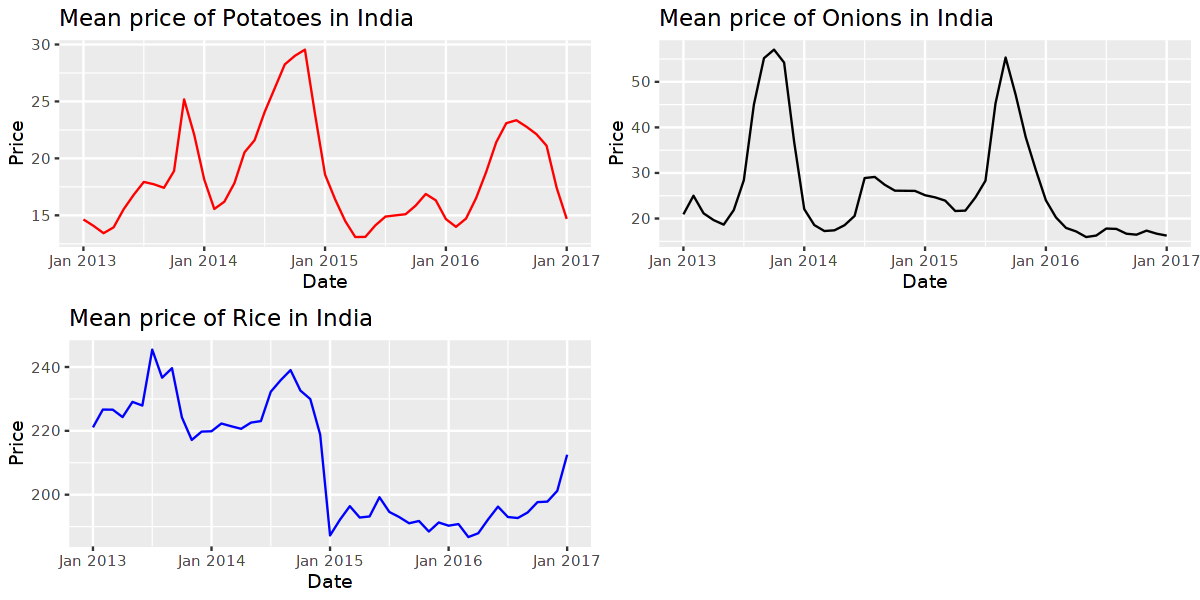

In [30]:
#Plotting potatoes, onions and rice prices in the training set

PotatoesPlot<-ggplot(df_india, aes(x=date, y=Potatoes))+
    geom_line(color="red")+
    ylab("Price") + 
    xlab("Date") +
    ggtitle('Mean price of Potatoes in India')

OnionsPlot<-ggplot(df_india, aes(x=date, y=Onions))+
    geom_line(color="black")+
    ylab("Price") + 
    xlab("Date") +
    ggtitle('Mean price of Onions in India')

RicePlot<-ggplot(df_india, aes(x=date, y=Rice))+
    geom_line(color="blue")+
    ylab("Price") + 
    xlab("Date") +
    ggtitle('Mean price of Rice in India')

grid.arrange(PotatoesPlot, 
            OnionsPlot, 
            RicePlot, 
            nrow=2, ncol=2
            )

Warning message in ggplot2::geom_segment(lineend = "butt", ...):
“Ignoring unknown parameters: `main`”
Warning message in ggplot2::geom_segment(lineend = "butt", ...):
“Ignoring unknown parameters: `main`”
Warning message in ggplot2::geom_segment(lineend = "butt", ...):
“Ignoring unknown parameters: `main`”


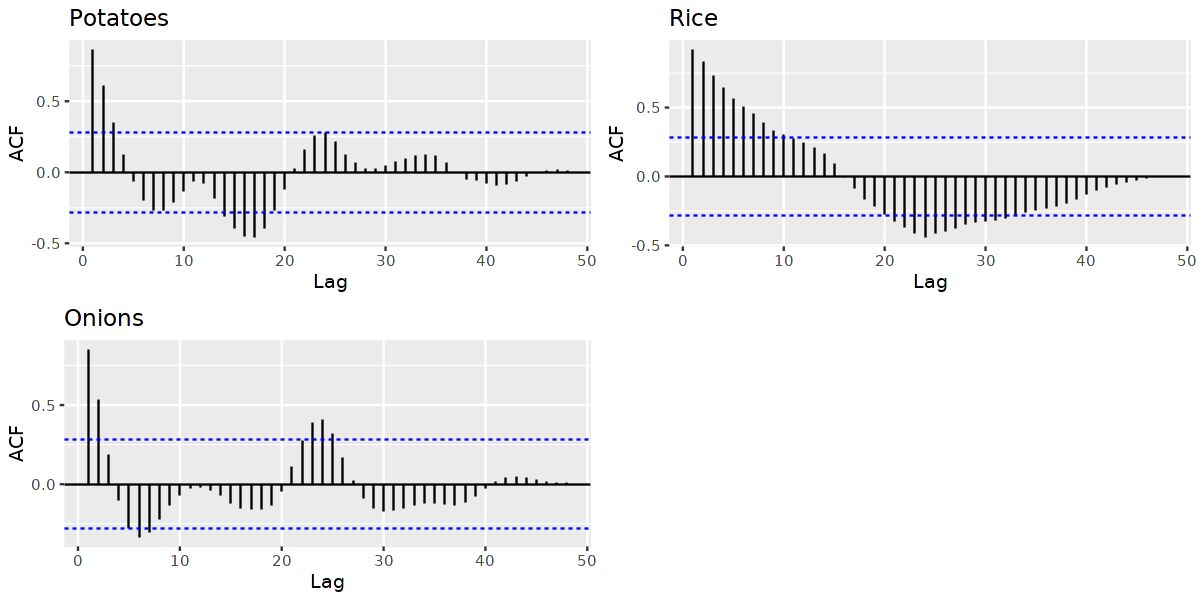

In [31]:
#Autocorrelation function plots

par(mfrow = c(2,2))

acf_Potatoes<-acf(df_india$Potatoes, lag.max=10000)
acf_Onions<-acf(df_india$Onions, lag.max=10000)
acf_Rice<-acf(df_india$Rice, lag.max=10000)

acf_PotatoesPlot<-autoplot(acf_Potatoes, main = "Potatoes")
acf_RicePlot<-autoplot(acf_Rice, main = "Rice")
acf_OnionsPlot<-autoplot(acf_Onions, main = "Onions")



grid.arrange(acf_PotatoesPlot, 
             acf_RicePlot,
             acf_OnionsPlot, 
             nrow=2, ncol=2
            )

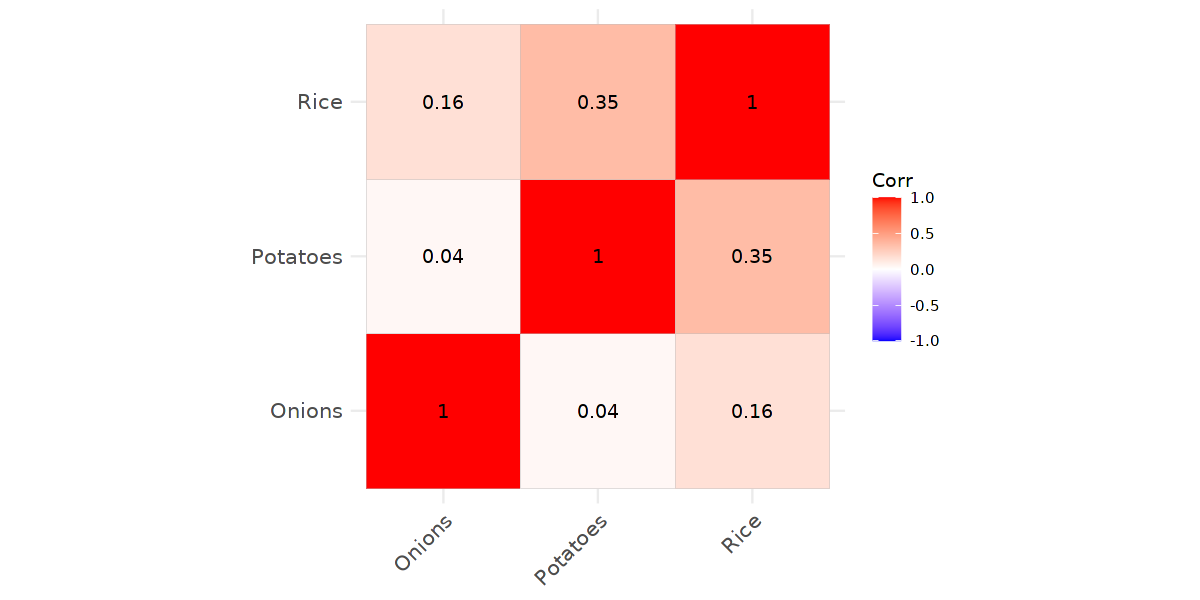

In [32]:
#correlation matrix
df_cor_food<-df_india[,c(4,5,8)]
ggcorrplot(cor(df_cor_food), 
            hc.order = TRUE,
            #type = "upper",
            lab = TRUE
            )

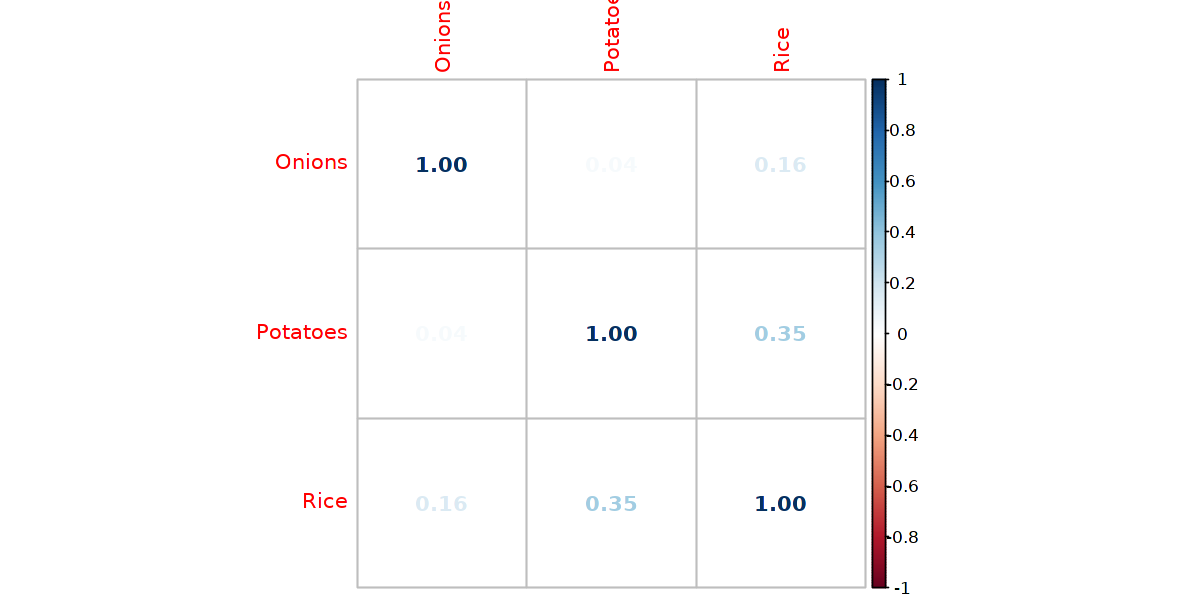

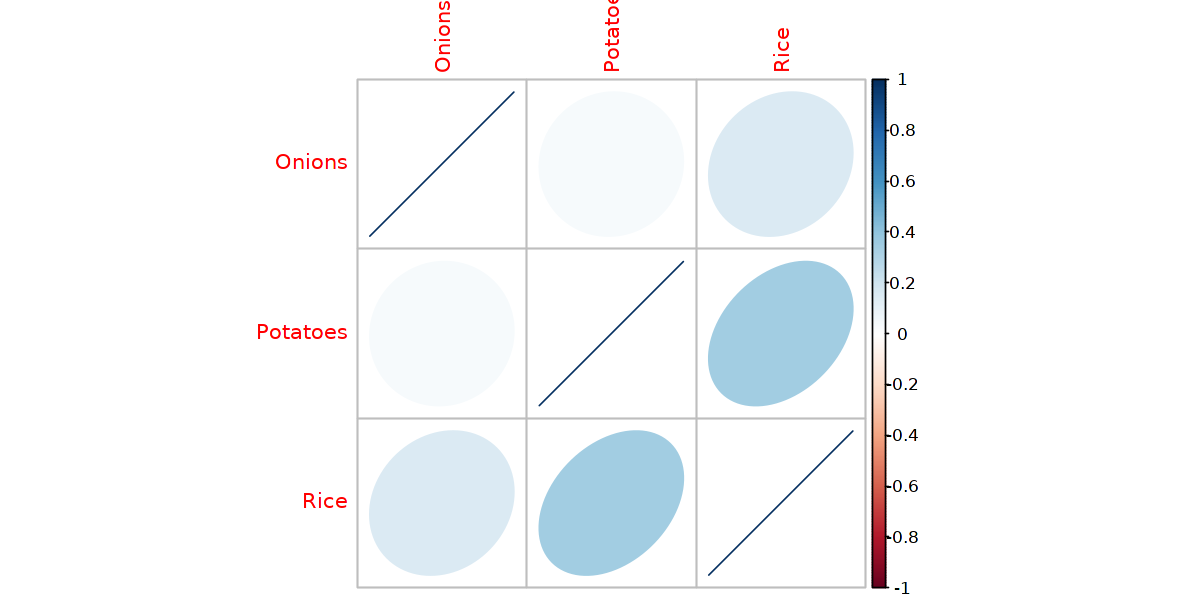

In [33]:
library("corrplot")

I = cor(df_cor_food)
corrplot(I, method = 'number', order = "alphabet")

corrplot(I, method = 'ellipse', type = 'full', order = 'alphabet')


### ARIMA food analysis

In [34]:
#Definitions of the training time series tibble objects

ts_Potatoes <- tibble(
  Date = yearmonth(df_india$date),
  value = df_india$Potatoes
)

tsibble_Potatoes<-as_tsibble(ts_Potatoes, index=Date)
tsibble_Potatoes<-fill_gaps(tsibble_Potatoes, .full = FALSE)

ts_Onions <- tibble(
  Date = yearmonth(df_india$date),
  value = df_india$Onions
)

tsibble_Onions<-as_tsibble(ts_Onions, index=Date)
tsibble_Onions<-fill_gaps(tsibble_Onions, .full = FALSE)

ts_Rice <- tibble(
  Date = yearmonth(df_india$date),
  value = df_india$Rice
)

tsibble_Rice<-as_tsibble(ts_Rice, index=Date)
tsibble_Rice<-fill_gaps(tsibble_Rice, .full = FALSE)

fitted_arima_model_Potatoes
1 <ARIMA(1,0,2)(1,1,0)[12]>

fitted_arima_model_Rice
1 <ARIMA(0,1,0)>

fitted_arima_model_Onions
1 <ARIMA(1,0,1)(1,1,0)[12]>

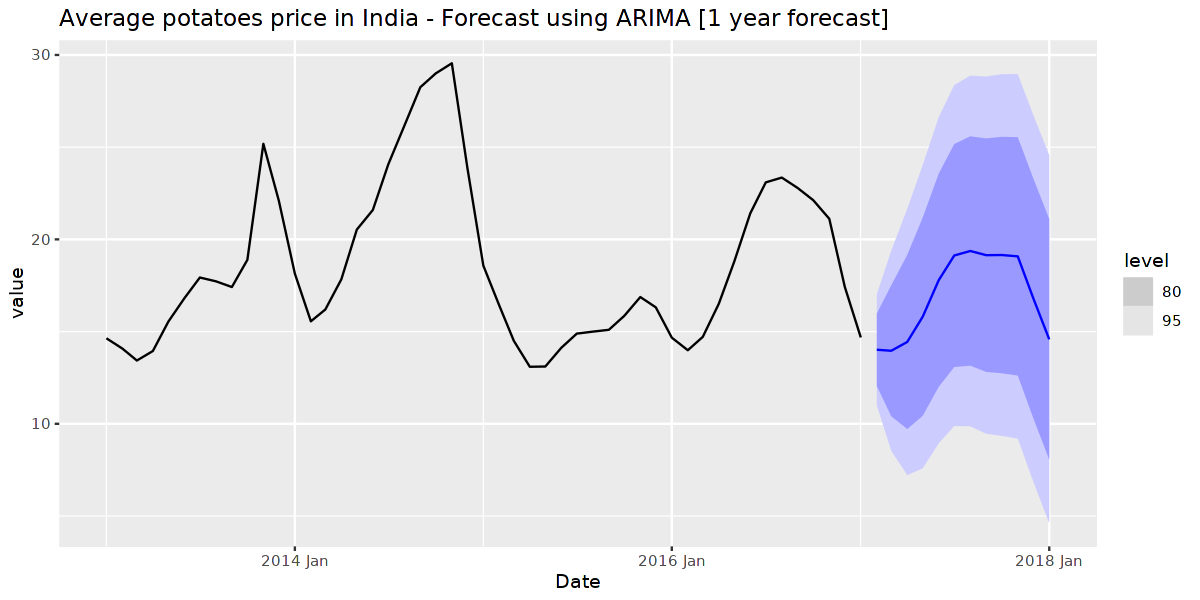

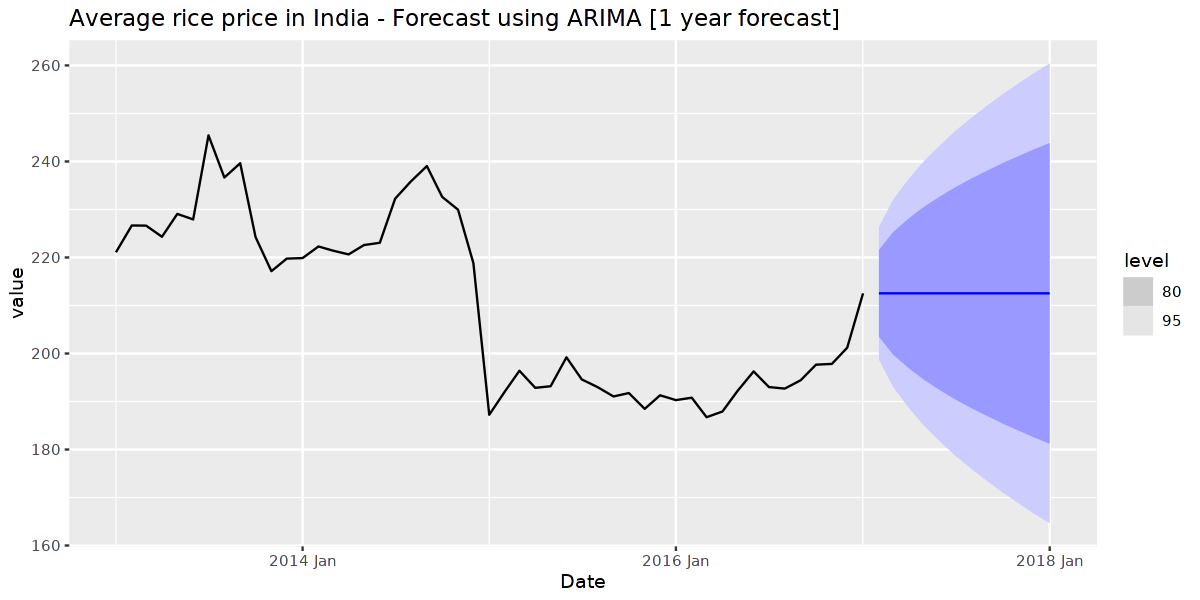

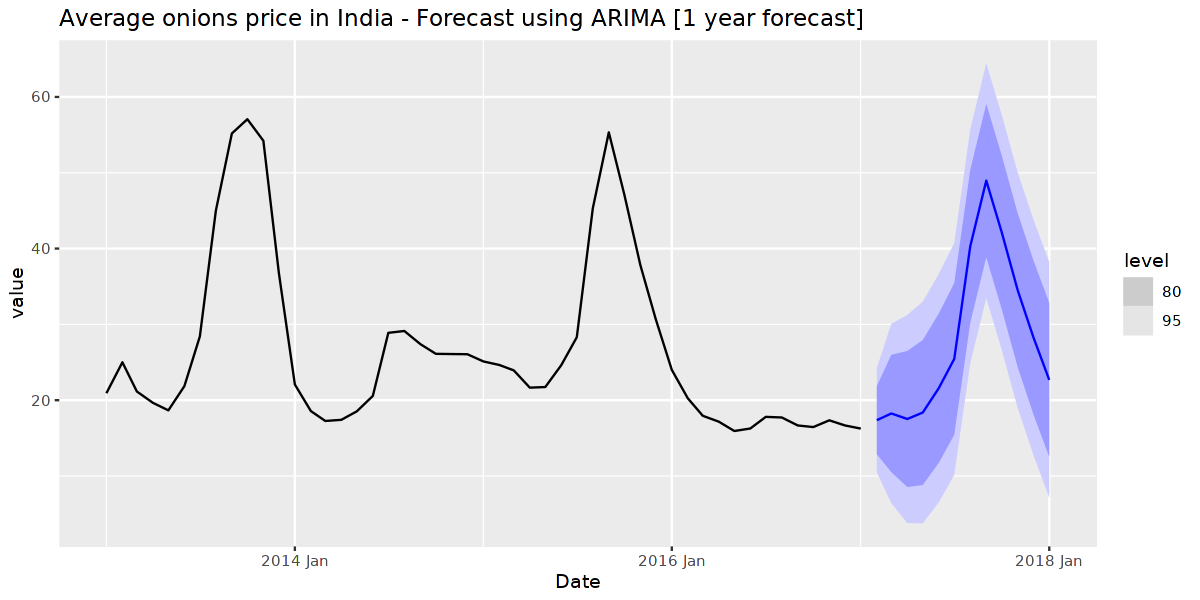

In [35]:
#ARIMA model fitting on the training set

fit_ts_Potatoes <- tsibble_Potatoes %>%
  model(fitted_arima_model_Potatoes = ARIMA(value ~ pdq() + PDQ()))

fit_ts_Rice<- tsibble_Rice %>%
  model(fitted_arima_model_Rice = ARIMA(value ~ pdq() + PDQ()))

fit_ts_Onions<- tsibble_Onions %>%
  model(fitted_arima_model_Onions = ARIMA(value ~ pdq() + PDQ()))

fit_ts_Potatoes

fit_ts_Rice

fit_ts_Onions

# Forcasting the time series using the fitted ARIMA model
fc_ts_Potatoes <- fit_ts_Potatoes %>%
  fabletools::forecast(h = 12)

fc_ts_Potatoes%>%
    autoplot(tsibble_Potatoes) + 
    ggtitle('Average potatoes price in India - Forecast using ARIMA [1 year forecast]')

# Forcasting the time series using the fitted ARIMA model
fc_ts_Rice <- fit_ts_Rice %>%
  fabletools::forecast(h = 12)

fc_ts_Rice%>%
    autoplot(tsibble_Rice) + 
    ggtitle('Average rice price in India - Forecast using ARIMA [1 year forecast]')

# Forcasting the time series using the fitted ARIMA model
fc_ts_Onions <- fit_ts_Onions %>%
  fabletools::forecast(h = 12)

fc_ts_Onions%>%
    autoplot(tsibble_Onions) + 
    ggtitle('Average onions price in India - Forecast using ARIMA [1 year forecast]')

In [36]:
#Definitions of the test time series tibble objects

#We work only with Potatoes and Onions because from the previous analysis we know that the rice
#prices are not correlated to the monsoon season

ts_Potatoes_test <- tibble(
  Date = yearmonth(df_india_test$date),
  value = df_india_test$Potatoes
)

tsibble_Potatoes_test <-as_tsibble(ts_Potatoes_test, index=Date)
tsibble_Potatoes_test <-fill_gaps(tsibble_Potatoes_test, .full = FALSE)

ts_Onions_test <- tibble(
  Date = yearmonth(df_india_test$date),
  value = df_india_test$Onions
)

tsibble_Onions_test <-as_tsibble(ts_Onions_test, index=Date)
tsibble_Onions_test <-fill_gaps(tsibble_Onions_test, .full = FALSE)

Using `Date` as index variable.
Using `Date` as index variable.


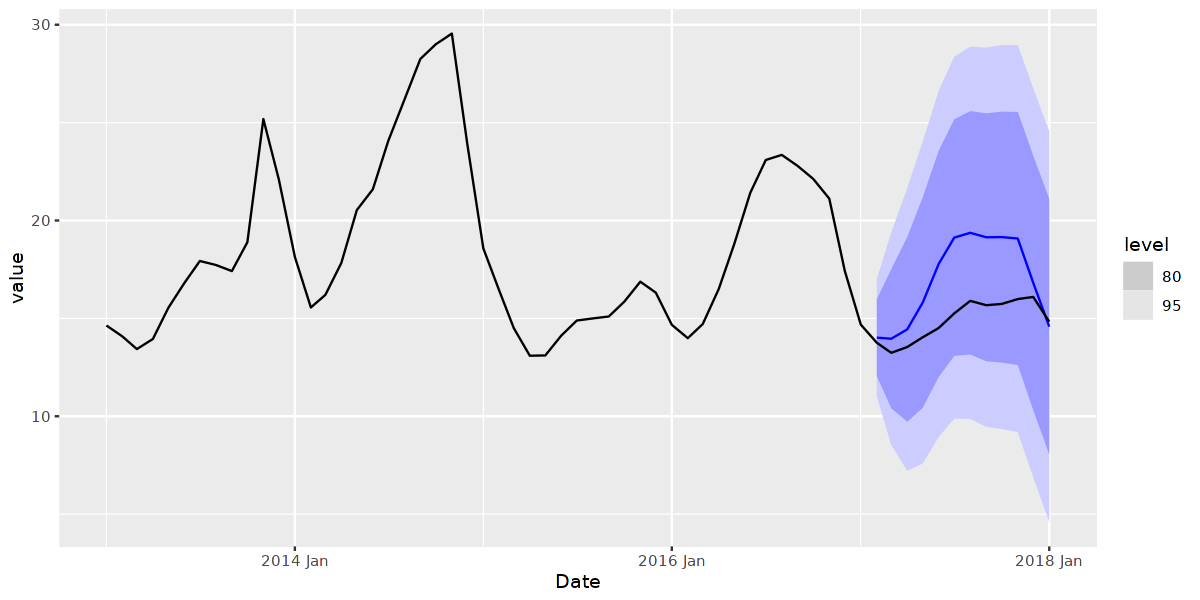

ERROR: Error in autoplot.fbl_ts(., ts_Rice_test): object 'ts_Rice_test' not found


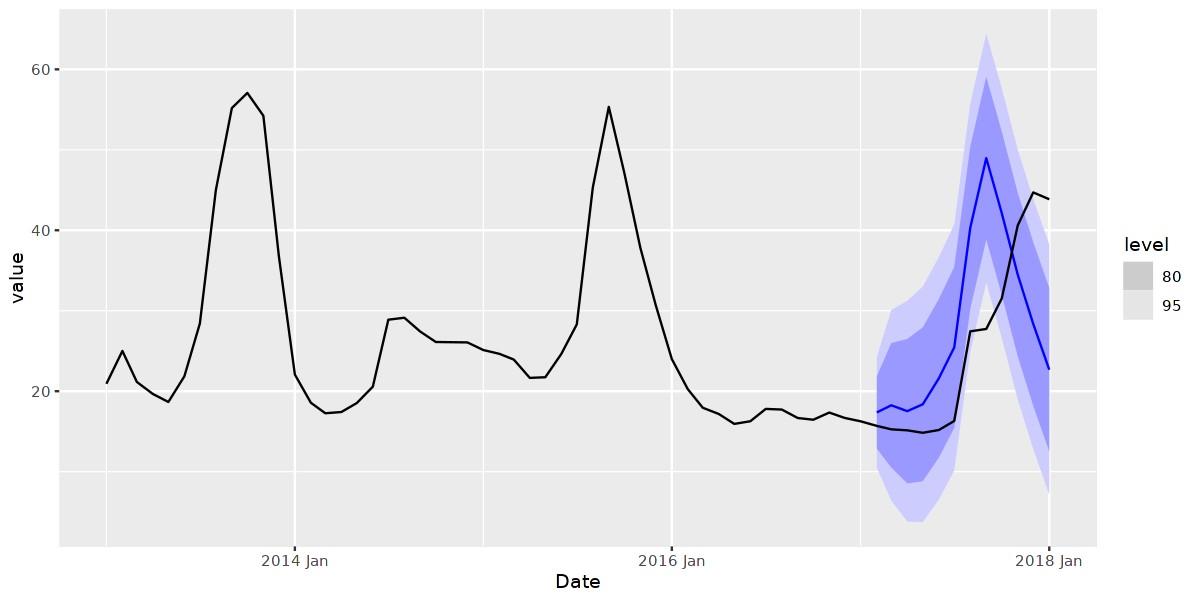

In [37]:
#Comparison between test set and forecast + accuracies -> we will compare RMSE of the two time
#series with the forecast using the ARIMA model from the temperature data

fc_ts_Potatoes %>%
    autoplot(ts_Potatoes_test)

fc_ts_Onions %>%
    autoplot(ts_Onions_test)

fc_ts_Rice %>%
    autoplot(ts_Rice_test)

fc_ts_Potatoes %>%
    fabletools::accuracy(tsibble_Potatoes_test)

fc_ts_Onions %>%
    fabletools::accuracy(tsibble_Onions_test)

fc_ts_Rice %>%
    fabletools::accuracy(tsibble_Rice_test)

### ARIMA fitting using seasonal coeff. from the weather analysis

fitted_arima_model_Potatoes
1 <ARIMA(0,0,0)(1,1,0)[12]>

fitted_arima_model_Onions
1 <ARIMA(0,0,0)(0,1,1)[12]>

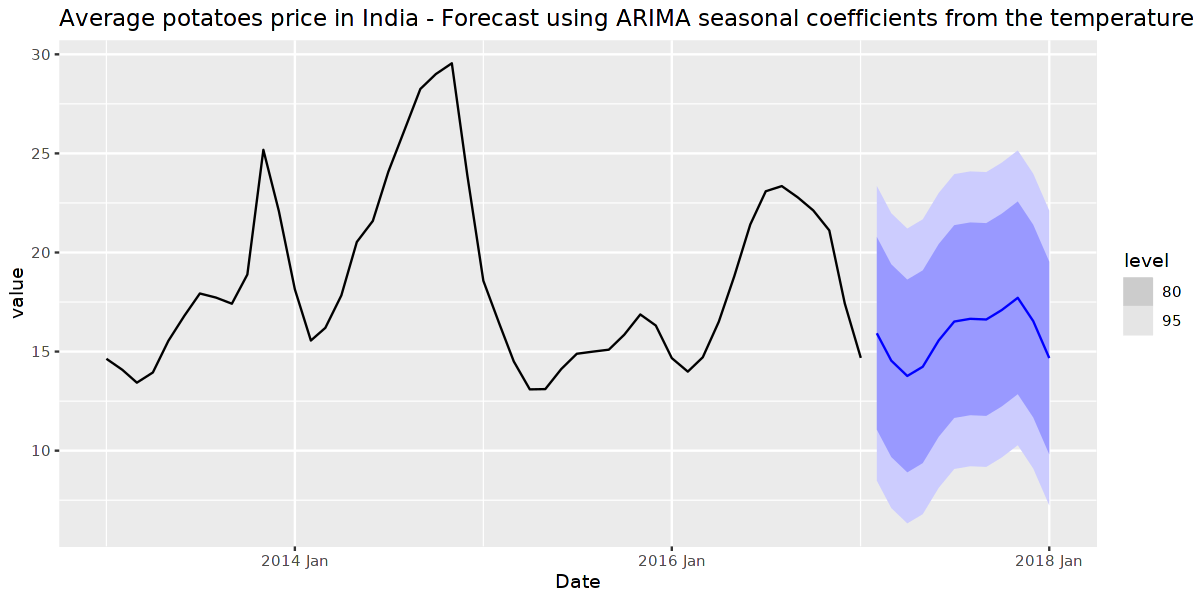

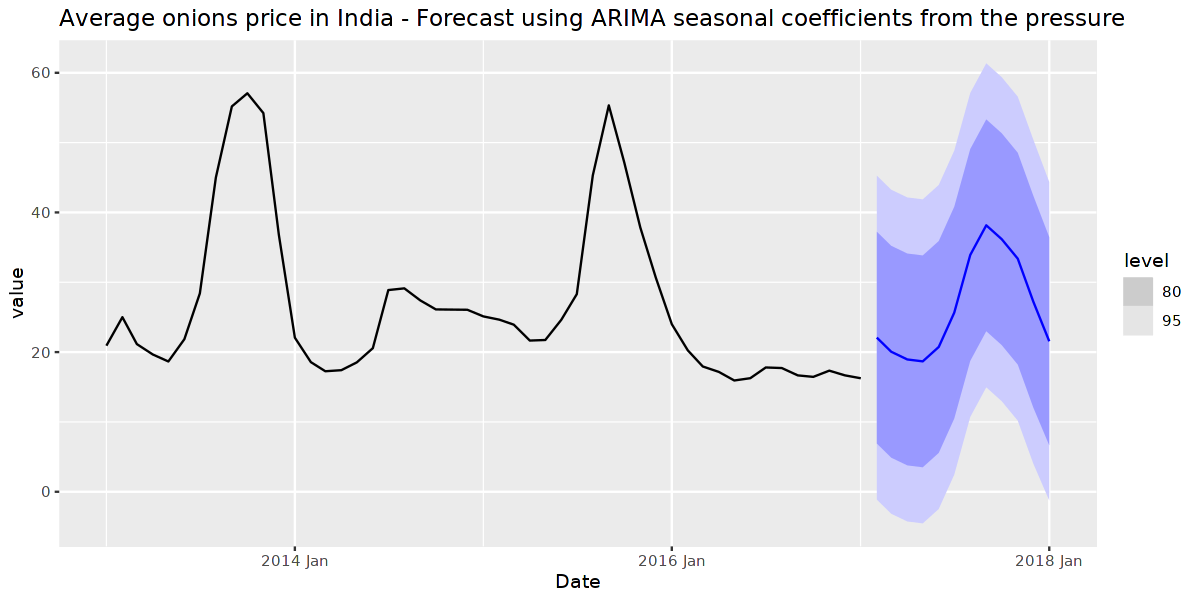

In [38]:
#ARIMA fitting using as ARIMA coefficients for the potatoes the ones from the temperature ARIMA
#fit: (0,0,0)(1,1,0) and as coefficients for the Onions fit the ones from the atmospheric
#pressure ARIMA fit: (0,0,0)(0,1,1)

fit_ts_Potatoes <- tsibble_Potatoes %>%
  model(fitted_arima_model_Potatoes = ARIMA(value ~ 0 + pdq(p=0, d=0, q=0) + PDQ(P=1, D=1, Q=0)))

fit_ts_Onions<- tsibble_Onions %>%
  model(fitted_arima_model_Onions = ARIMA(value ~ 0 + pdq(p=0, d=0, q=0) + PDQ(P=0, D=1, Q=1)))

fit_ts_Potatoes

fit_ts_Onions

# Forcasting the time series using the fitted ARIMA model
fc_ts_Potatoes <- fit_ts_Potatoes %>%
  fabletools::forecast(h = 12)

fc_ts_Potatoes %>%
    autoplot(tsibble_Potatoes) + 
    ggtitle('Average potatoes price in India - Forecast using ARIMA seasonal coefficients from the temperature')

# Forcasting the time series using the fitted ARIMA model
fc_ts_Onions <- fit_ts_Onions %>%
  fabletools::forecast(h = 12)

fc_ts_Onions %>%
    autoplot(tsibble_Onions) + 
    ggtitle('Average onions price in India - Forecast using ARIMA seasonal coefficients from the pressure')

Using `Date` as index variable.
Using `Date` as index variable.


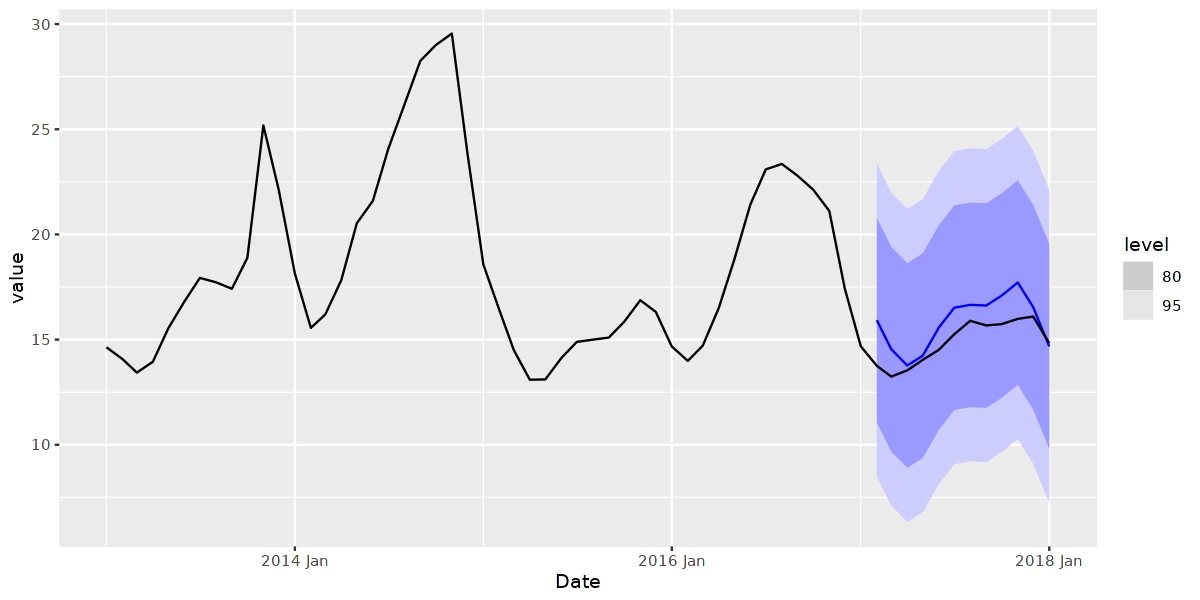

.model                      .type ME         RMSE     MAE       MPE      
1 fitted_arima_model_Potatoes Test  -0.9417113 1.145028 0.9677027 -6.354587
  MAPE     MASE      RMSSE     ACF1     
1 6.529871 0.1693308 0.1679719 0.2145277

.model                    .type ME         RMSE     MAE      MPE      
1 fitted_arima_model_Onions Test  -0.6923627 10.15639 8.522917 -15.45419
  MAPE    MASE      RMSSE     ACF1     
1 33.4052 0.7538553 0.6549341 0.6313942

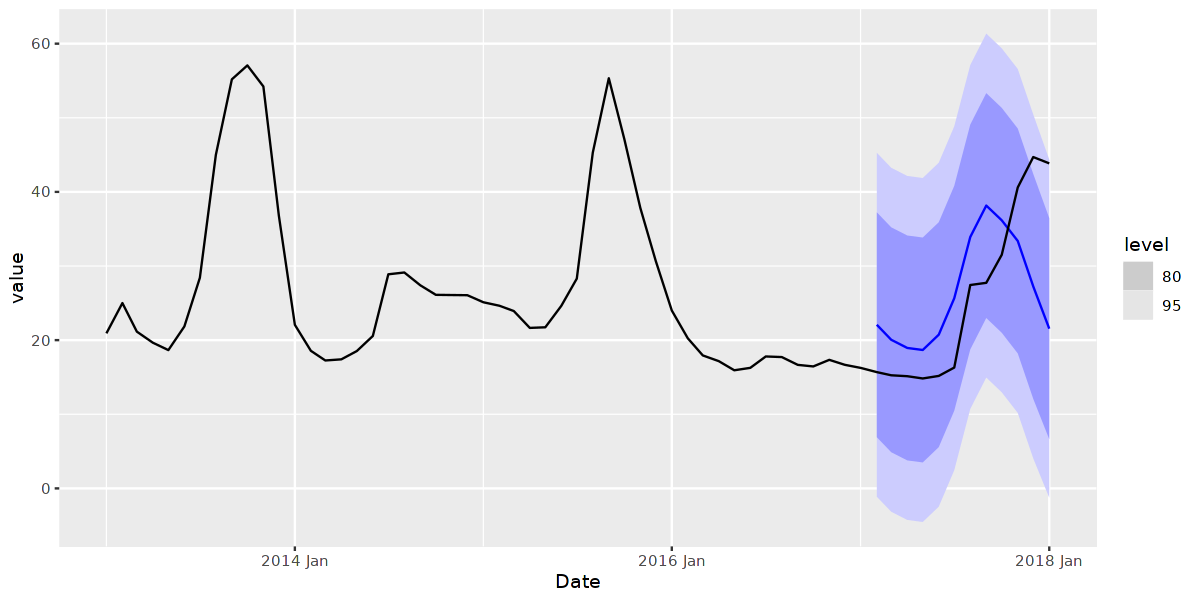

In [39]:
#Comparison between test set and forecast + accuracies -> comparing these RMSE with the ones of
#the previous fit we notice that we have an improvmenet. We managed to improve the accuracy of the
#fit by using the seasonal ARIMA coefficients from the weather analysis in Delhi

fc_ts_Potatoes %>%
    autoplot(ts_Potatoes_test)

fc_ts_Onions %>%
    autoplot(ts_Onions_test)

fc_ts_Potatoes %>%
    fabletools::accuracy(tsibble_Potatoes_test)

fc_ts_Onions %>%
    fabletools::accuracy(tsibble_Onions_test)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=74b70e33-4e05-40e8-88b0-215b255c9984' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>